# Sentiment Event Correlation Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy import stats
from scipy.signal import correlate
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.formula.api import ols
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib.patches import Rectangle

# Load Data

In [2]:
df_sentiment_events = pd.read_csv('../data/sentiment_temporal/significant_events.csv',)
df_wiki_time_period = pd.read_csv('../data/wikipedia/Gaza_war_time_periods.csv')

In [3]:
df_sentiment_events

,date,detection_count,methods,metrics,hebrew_sentiment,arabic_sentiment,hebrew_messages,arabic_messages
0,2024-10-15,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-11.700183,-70.565046,547,761
1,2025-02-07,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-5.726872,-55.371901,227,484
2,2024-06-17,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-11.158798,-72.564612,233,503
3,2023-11-30,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-5.500000,-54.379562,400,548
4,2025-02-02,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-8.547009,-49.364407,234,472
5,2025-01-13,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-4.779412,-76.833977,272,518
6,2024-06-07,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-14.215686,-71.760797,204,602
7,2024-04-08,18,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-6.440678,-67.238095,295,525
8,2024-04-23,18,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-12.658228,-66.256831,237,732
9,2023-10-21,18,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-11.111111,-63.626126,405,888


In [4]:
df_wiki_time_period

,title,period,start_date,end_date,duration_days,level,indented_title
0,Initial Israeli counter-operation (October 2023),October 2023,2023-10-01,2023-10-31,31,3,Initial Israeli counter-operation (October 2...
1,Initial invasion to first truce (October–Novem...,November 2023,2023-11-01,2023-11-30,30,3,Initial invasion to first truce (October–Nov...
2,First ceasefire (November 2023),November 2023,2023-11-01,2023-11-30,30,3,First ceasefire (November 2023)
3,Resumption of hostilities (December 2023 – Jan...,December 2023,2023-12-01,2023-12-31,31,3,Resumption of hostilities (December 2023 – J...
4,Build-up to the Rafah offensive (February–Apri...,April 2024,2024-04-01,2024-04-30,30,3,Build-up to the Rafah offensive (February–Ap...
5,Beginning of the Rafah offensive (May–July 2024),July 2024,2024-07-01,2024-07-31,31,3,Beginning of the Rafah offensive (May–July 2...
6,"Rafah, Khan Yunis, and general bombardment (Ju...",September 2024,2024-09-01,2024-09-30,30,3,"Rafah, Khan Yunis, and general bombardment (..."
7,Continued operations throughout Gaza (October–...,December 2024,2024-12-01,2024-12-31,31,3,Continued operations throughout Gaza (Octobe...
8,Second ceasefire (January–March 2025),March 2025,2025-03-01,2025-03-31,31,3,Second ceasefire (January–March 2025)
9,7 October Hamas-led attack on Israel,7 October 2023,2023-10-07,2023-10-07,1,3,7 October Hamas-led attack on Israel


# Data Preprocessing

The `Gaza_war_time_periods.csv` data isn't properly preprocessed to reflect the full date ranges mentioned in the titles. We'll fix that with an improved preprocessing step:

In [5]:
def preprocess_wiki_timeline(wiki_events_path):
    """
    Preprocess Wikipedia timeline events to ensure correct date ranges based on title information.

    Parameters:
    -----------
    wiki_events_path : str
        Path to the CSV file containing Wikipedia timeline events

    Returns:
    --------
    pandas.DataFrame
        Preprocessed Wikipedia events with corrected date ranges
    """
    # Load Wikipedia events dataset
    wiki_events = pd.read_csv(wiki_events_path)

    print(f"Original Wikipedia events: {len(wiki_events)}")

    # Convert existing dates to datetime
    wiki_events['start_date'] = pd.to_datetime(wiki_events['start_date'])
    wiki_events['end_date'] = pd.to_datetime(wiki_events['end_date'])

    # Regular expression patterns to extract date ranges from titles
    month_year_pattern = r'(?:\(|\s)([A-Za-z]+(?:–[A-Za-z]+)?)\s+(\d{4})(?:–([A-Za-z]+)\s+(\d{4}))?(?:\)|\s|$)'
    specific_date_pattern = r'(\d{1,2}\s+[A-Za-z]+)'

    # Map month names to numbers
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }

    # Function to parse date ranges from titles
    def extract_date_range(title):
        """Extract date range from title and return start and end dates."""
        title = str(title)

        # Check for specific date (e.g., "7 October")
        specific_match = re.search(specific_date_pattern, title)
        if specific_match:
            date_str = specific_match.group(1)
            try:
                # Parse day and month
                day, month_name = date_str.split()
                month = month_map.get(month_name, 10)  # Default to October if not found

                # Assume year 2023 for the specific date (update as needed)
                year = 2023
                return datetime(year, month, int(day)), datetime(year, month, int(day))
            except:
                pass

        # Try to extract month-year range from title
        match = re.search(month_year_pattern, title)
        if match:
            groups = match.groups()

            # Extract first month or month range and year
            first_month_range = groups[0]
            first_year = int(groups[1])

            # Check if there's a month range (e.g., "May–July")
            if '–' in first_month_range:
                start_month_name, end_month_name = first_month_range.split('–')
                start_month = month_map.get(start_month_name, 1)
                end_month = month_map.get(end_month_name, 12)
            else:
                start_month = end_month = month_map.get(first_month_range, 1)

            # Set start date to first day of start month
            start_date = datetime(first_year, start_month, 1)

            # Check if there's a second date range (e.g., "December 2023 – January 2024")
            if groups[2] and groups[3]:
                end_month_name = groups[2]
                end_year = int(groups[3])
                end_month = month_map.get(end_month_name, 12)
                # Set end date to last day of end month
                if end_month == 12:
                    end_date = datetime(end_year, 12, 31)
                else:
                    next_month = datetime(end_year, end_month + 1, 1)
                    end_date = next_month - timedelta(days=1)
            else:
                # If only one month mentioned, set end date to last day of that month
                if end_month == 12:
                    end_date = datetime(first_year, 12, 31)
                else:
                    next_month = datetime(first_year, end_month + 1, 1)
                    end_date = next_month - timedelta(days=1)

            return start_date, end_date

        # If no match found, return None values
        return None, None

    # Extract date ranges from titles
    corrected_dates = []
    for _, row in wiki_events.iterrows():
        start_date, end_date = extract_date_range(row['title'])

        if start_date and end_date:
            corrected_dates.append({
                'title': row['title'],
                'extracted_start_date': start_date,
                'extracted_end_date': end_date,
                'original_start_date': row['start_date'],
                'original_end_date': row['end_date']
            })
        else:
            corrected_dates.append({
                'title': row['title'],
                'extracted_start_date': None,
                'extracted_end_date': None,
                'original_start_date': row['start_date'],
                'original_end_date': row['end_date']
            })

    corrections_df = pd.DataFrame(corrected_dates)

    # Update wiki_events with corrected dates
    for i, row in corrections_df.iterrows():
        if row['extracted_start_date'] is not None:
            wiki_events.loc[i, 'start_date'] = row['extracted_start_date']
        if row['extracted_end_date'] is not None:
            wiki_events.loc[i, 'end_date'] = row['extracted_end_date']

    # Update the period column to reflect the corrected date range
    wiki_events['period'] = wiki_events.apply(
        lambda row: f"{row['start_date'].strftime('%B %Y')} - {row['end_date'].strftime('%B %Y')}"
                   if row['start_date'].strftime('%B %Y') != row['end_date'].strftime('%B %Y')
                   else row['start_date'].strftime('%B %Y'),
        axis=1
    )

    # Print statistics on corrected dates
    extracted_count = sum([1 for x in corrections_df['extracted_start_date'] if x is not None])
    print(f"Successfully extracted date ranges for {extracted_count} of {len(wiki_events)} Wikipedia events")

    # Check if any events still don't have valid date ranges
    invalid_ranges = wiki_events[wiki_events['start_date'] > wiki_events['end_date']]
    if len(invalid_ranges) > 0:
        print(f"Warning: {len(invalid_ranges)} events have start_date > end_date, fixing...")
        # Fix by swapping start and end dates
        wiki_events.loc[invalid_ranges.index, ['start_date', 'end_date']] = wiki_events.loc[
            invalid_ranges.index, ['end_date', 'start_date']].values

    return wiki_events

In [6]:
# Preprocess Wikipedia events to ensure correct date ranges
wiki_events = preprocess_wiki_timeline('../data/wikipedia/Gaza_war_time_periods.csv')

Original Wikipedia events: 10
Successfully extracted date ranges for 10 of 10 Wikipedia events


In [7]:
wiki_events

,title,period,start_date,end_date,duration_days,level,indented_title
0,Initial Israeli counter-operation (October 2023),October 2023,2023-10-01,2023-10-31,31,3,Initial Israeli counter-operation (October 2...
1,Initial invasion to first truce (October–Novem...,October 2023 - November 2023,2023-10-01,2023-11-30,30,3,Initial invasion to first truce (October–Nov...
2,First ceasefire (November 2023),November 2023,2023-11-01,2023-11-30,30,3,First ceasefire (November 2023)
3,Resumption of hostilities (December 2023 – Jan...,December 2023,2023-12-01,2023-12-31,31,3,Resumption of hostilities (December 2023 – J...
4,Build-up to the Rafah offensive (February–Apri...,February 2024 - April 2024,2024-02-01,2024-04-30,30,3,Build-up to the Rafah offensive (February–Ap...
5,Beginning of the Rafah offensive (May–July 2024),May 2024 - July 2024,2024-05-01,2024-07-31,31,3,Beginning of the Rafah offensive (May–July 2...
6,"Rafah, Khan Yunis, and general bombardment (Ju...",July 2024 - September 2024,2024-07-01,2024-09-30,30,3,"Rafah, Khan Yunis, and general bombardment (..."
7,Continued operations throughout Gaza (October–...,October 2024 - December 2024,2024-10-01,2024-12-31,31,3,Continued operations throughout Gaza (Octobe...
8,Second ceasefire (January–March 2025),January 2025 - March 2025,2025-01-01,2025-03-31,31,3,Second ceasefire (January–March 2025)
9,7 October Hamas-led attack on Israel,October 2023,2023-10-07,2023-10-07,1,3,7 October Hamas-led attack on Israel


In [8]:
wiki_events.to_csv('../data/wikipedia/wiki_time_periods.csv', index=False)

# Temporal Matching

## Data Preparation and Integration

In [9]:
def prepare_and_integrate_data(sentiment_events_path, wiki_events_path):
    """
    Load, preprocess, and integrate sentiment events with Wikipedia timeline events.

    Parameters:
    -----------
    sentiment_events_path : str
        Path to the CSV file containing sentiment-detected events
    wiki_events_path : str
        Path to the CSV file containing Wikipedia timeline events

    Returns:
    --------
    pandas.DataFrame
        Integrated dataset with matched events
    """
    # Load and preprocess sentiment events
    sentiment_events = pd.read_csv(sentiment_events_path)
    sentiment_events['date'] = pd.to_datetime(sentiment_events['date'])
    sentiment_events = sentiment_events.sort_values('date')

    # Preprocess Wikipedia events to ensure correct date ranges
    wiki_events = preprocess_wiki_timeline(wiki_events_path)

    print(f"\nProcessing {len(sentiment_events)} sentiment events against {len(wiki_events)} Wikipedia events")

    # Function to find matching Wiki period for a given date
    def find_matching_wiki_period(event_date, wiki_events_df):
        """Find the Wikipedia period that contains the given event date."""
        matched_periods = []

        for _, wiki_row in wiki_events_df.iterrows():
            start_date = wiki_row['start_date']
            end_date = wiki_row['end_date']

            if start_date <= event_date <= end_date:
                # Calculate relative position within the period (0-1)
                total_days = (end_date - start_date).days + 1  # +1 to include both start and end days
                days_in = (event_date - start_date).days
                relative_position = days_in / max(1, total_days)  # Avoid division by zero

                matched_periods.append({
                    'wiki_title': wiki_row['title'],
                    'wiki_period': wiki_row['period'],
                    'relative_position': relative_position,
                    'days_from_period_start': days_in,
                    'days_to_period_end': (end_date - event_date).days,
                    'period_duration': total_days
                })

        if matched_periods:
            # If multiple matches, prioritize the one with the most specific (shortest) period
            matched_periods.sort(key=lambda x: x['period_duration'])
            return matched_periods[0]

        # If no matching period is found
        return {
            'wiki_title': 'No matching period',
            'wiki_period': None,
            'relative_position': None,
            'days_from_period_start': None,
            'days_to_period_end': None,
            'period_duration': None
        }

    # Apply matching function to each sentiment event
    matches = []
    for _, row in sentiment_events.iterrows():
        match_info = find_matching_wiki_period(row['date'], wiki_events)
        matches.append(match_info)

    # Add matching information to sentiment_events dataframe
    match_df = pd.DataFrame(matches)
    sentiment_events_matched = pd.concat([sentiment_events.reset_index(drop=True), match_df], axis=1)

    # Calculate earliest and latest dates for conflict stage determination
    earliest_date = wiki_events['start_date'].min()
    latest_date = wiki_events['end_date'].max()
    total_conflict_duration = (latest_date - earliest_date).days + 1

    # Function to determine conflict stage
    def determine_conflict_stage(row):
        """Determine if the event is in early, middle, or late stage of the conflict"""
        if pd.isnull(row['relative_position']):
            return "Unknown"

        days_from_start = (row['date'] - earliest_date).days
        relative_overall_position = days_from_start / total_conflict_duration

        if relative_overall_position < 0.33:
            return "Early"
        elif relative_overall_position < 0.66:
            return "Middle"
        else:
            return "Late"

    # Add conflict stage to dataframe
    sentiment_events_matched['conflict_stage'] = sentiment_events_matched.apply(determine_conflict_stage, axis=1)

    # Function to determine event type
    def determine_event_type(title):
        """Determine the type of event based on the Wiki title"""
        if pd.isnull(title) or title == 'No matching period':
            return "Unknown"

        title_lower = title.lower()

        if 'ceasefire' in title_lower or 'truce' in title_lower:
            return "Ceasefire/Truce"
        elif 'attack' in title_lower:
            return "Attack"
        elif 'invasion' in title_lower or 'offensive' in title_lower:
            return "Military Operation"
        elif 'build-up' in title_lower:
            return "Preparation"
        elif 'operation' in title_lower:
            return "Military Operation"
        elif 'bombardment' in title_lower:
            return "Bombardment"
        else:
            return "Other"

    # Add event type to dataframe
    sentiment_events_matched['event_type'] = sentiment_events_matched['wiki_title'].apply(determine_event_type)

    # Add period timing information
    sentiment_events_matched['period_timing'] = 'Mid-period'
    sentiment_events_matched.loc[sentiment_events_matched['relative_position'] < 0.25, 'period_timing'] = 'Early-period'
    sentiment_events_matched.loc[sentiment_events_matched['relative_position'] > 0.75, 'period_timing'] = 'Late-period'

    # Count matches and non-matches
    matched = sentiment_events_matched['wiki_title'] != 'No matching period'
    print(f"Matched {matched.sum()} of {len(sentiment_events_matched)} events to Wikipedia periods")

    return sentiment_events_matched


## integrated dataset

In [10]:
integrated_data = prepare_and_integrate_data(sentiment_events_path='../data/sentiment_temporal/significant_events.csv',
                                             wiki_events_path='../data/wikipedia/wiki_time_periods.csv')

Original Wikipedia events: 10
Successfully extracted date ranges for 10 of 10 Wikipedia events

Processing 10 sentiment events against 10 Wikipedia events
Matched 10 of 10 events to Wikipedia periods


In [11]:
integrated_data

,date,detection_count,methods,metrics,hebrew_sentiment,arabic_sentiment,hebrew_messages,arabic_messages,wiki_title,wiki_period,relative_position,days_from_period_start,days_to_period_end,period_duration,conflict_stage,event_type,period_timing
0,2023-10-21,18,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-11.111111,-63.626126,405,888,Initial Israeli counter-operation (October 2023),October 2023,0.645161,20,10,31,Early,Military Operation,Mid-period
1,2023-11-30,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-5.500000,-54.379562,400,548,First ceasefire (November 2023),November 2023,0.966667,29,0,30,Early,Ceasefire/Truce,Late-period
2,2024-04-08,18,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-6.440678,-67.238095,295,525,Build-up to the Rafah offensive (February–Apri...,February 2024 - April 2024,0.744444,67,22,90,Middle,Military Operation,Mid-period
3,2024-04-23,18,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-12.658228,-66.256831,237,732,Build-up to the Rafah offensive (February–Apri...,February 2024 - April 2024,0.911111,82,7,90,Middle,Military Operation,Late-period
4,2024-06-07,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-14.215686,-71.760797,204,602,Beginning of the Rafah offensive (May–July 2024),May 2024 - July 2024,0.402174,37,54,92,Middle,Military Operation,Mid-period
5,2024-06-17,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-11.158798,-72.564612,233,503,Beginning of the Rafah offensive (May–July 2024),May 2024 - July 2024,0.510870,47,44,92,Middle,Military Operation,Mid-period
6,2024-10-15,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-11.700183,-70.565046,547,761,Continued operations throughout Gaza (October–...,October 2024 - December 2024,0.152174,14,77,92,Late,Military Operation,Early-period
7,2025-01-13,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-4.779412,-76.833977,272,518,Second ceasefire (January–March 2025),January 2025 - March 2025,0.133333,12,77,90,Late,Ceasefire/Truce,Early-period
8,2025-02-02,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-8.547009,-49.364407,234,472,Second ceasefire (January–March 2025),January 2025 - March 2025,0.355556,32,57,90,Late,Ceasefire/Truce,Mid-period
9,2025-02-07,19,"CUSUM, Ruptures","sentiment_index, net_sentiment, message_volume...",-5.726872,-55.371901,227,484,Second ceasefire (January–March 2025),January 2025 - March 2025,0.411111,37,52,90,Late,Ceasefire/Truce,Mid-period


In [12]:
# Display a sample of the integrated dataset
print("\nSample of integrated dataset:")
display_cols = ['date', 'hebrew_sentiment', 'arabic_sentiment',
               'wiki_title', 'wiki_period', 'relative_position',
               'conflict_stage', 'event_type', 'period_timing']
integrated_data[display_cols].head()


Sample of integrated dataset:


,date,hebrew_sentiment,arabic_sentiment,wiki_title,wiki_period,relative_position,conflict_stage,event_type,period_timing
0,2023-10-21,-11.111111,-63.626126,Initial Israeli counter-operation (October 2023),October 2023,0.645161,Early,Military Operation,Mid-period
1,2023-11-30,-5.500000,-54.379562,First ceasefire (November 2023),November 2023,0.966667,Early,Ceasefire/Truce,Late-period
2,2024-04-08,-6.440678,-67.238095,Build-up to the Rafah offensive (February–Apri...,February 2024 - April 2024,0.744444,Middle,Military Operation,Mid-period
3,2024-04-23,-12.658228,-66.256831,Build-up to the Rafah offensive (February–Apri...,February 2024 - April 2024,0.911111,Middle,Military Operation,Late-period
4,2024-06-07,-14.215686,-71.760797,Beginning of the Rafah offensive (May–July 2024),May 2024 - July 2024,0.402174,Middle,Military Operation,Mid-period


In [13]:
# Show the distribution of matched events by period
if len(integrated_data) > 0:
    print("\nDistribution of sentiment events by Wikipedia period:")
    period_counts = integrated_data['wiki_period'].value_counts()
    for period, count in period_counts.items():
        print(f"- {period}: {count} events")


Distribution of sentiment events by Wikipedia period:
- January 2025 - March 2025: 3 events
- February 2024 - April 2024: 2 events
- May 2024 - July 2024: 2 events
- October 2023: 1 events
- November 2023: 1 events
- October 2024 - December 2024: 1 events


In [14]:
# Save the integrated dataset for further analysis
integrated_data.to_csv('../data/sentiment_events/integrated_events.csv', index=False)
print("\nIntegrated dataset saved to '../data/sentiment_events/integrated_events.csv'")


Integrated dataset saved to '../data/sentiment_events/integrated_events.csv'


# Exploratory Analysis and Visualization

1. **Timeline Overlay Visualization:**
    - Shows Hebrew (blue) and Arabic (green) sentiment events plotted against time
    - Annotates key Wikipedia events directly on the timeline with yellow boxes
    - Allows for easy visual correlation between sentiment shifts and documented events

2. **Sentiment Temporal Plot with Period Backgrounds:**
    - Displays Hebrew and Arabic sentiment trends over time as connected lines
    - Uses color-coded background shading to indicate different Wikipedia periods/events
    - Helps identify how sentiment evolved during specific conflict phases

3. **Mean Sentiment by Event Type:**
    - Bar chart comparing Hebrew and Arabic mean sentiment across different event types
    - Reveals which types of events (Ceasefire, Attack, Military Operation, etc.) triggered different sentiment responses
    - Highlights sentiment divergence or convergence between the two communities

4. **Mean Sentiment by Conflict Stage:**
    - Compares sentiment changes across early, middle, and late conflict stages
    - Includes sample sizes for statistical context
    - Shows how sentiment evolved over the broader conflict timeline

In [15]:
def exploratory_analysis_visualization(integrated_data_path, wiki_timeline_path, output_path=None):
    """
    Perform exploratory analysis and create visualizations for the integrated sentiment and wiki event data.

    Parameters:
    -----------
    integrated_data_path : str
        Path to the CSV file containing integrated sentiment and wiki events
    wiki_timeline_path : str
        Path to the CSV file containing preprocessed Wikipedia timeline
    output_path : str, optional
        Path to save visualization outputs, if None will display instead
    """
    # Load the integrated data and wiki timeline
    integrated_data = pd.read_csv(integrated_data_path)
    wiki_timeline = pd.read_csv(wiki_timeline_path)

    # Convert date columns to datetime
    integrated_data['date'] = pd.to_datetime(integrated_data['date'])
    wiki_timeline['start_date'] = pd.to_datetime(wiki_timeline['start_date'])
    wiki_timeline['end_date'] = pd.to_datetime(wiki_timeline['end_date'])

    # Sort data chronologically
    integrated_data = integrated_data.sort_values('date')
    wiki_timeline = wiki_timeline.sort_values('start_date')

    # Set plotting style
    # sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12, 'figure.figsize': (14, 10)})

    # 1. Overlay Timeline Visualization
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot Hebrew sentiment events
    ax.scatter(integrated_data['date'], integrated_data['hebrew_sentiment'],
               s=100, color='blue', alpha=0.7, label='Hebrew Sentiment')

    # Plot Arabic sentiment events
    ax.scatter(integrated_data['date'], integrated_data['arabic_sentiment'],
               s=100, color='green', alpha=0.7, label='Arabic Sentiment')

    # Create background zones for significant Wikipedia events
    # Get current y-axis limits
    y_min, y_max = ax.get_ylim()

    for i, row in wiki_timeline.iterrows():
        # Get period start and end date
        start_date = row['start_date']
        end_date = row['end_date']

        # Create a shorter title for display
        short_title = row['title'].split('(')[0].strip()
        if len(short_title) > 30:
            short_title = short_title[:27] + '...'

        # Calculate a position at the bottom of the chart (above x-axis)
        event_date = start_date + (end_date - start_date) / 2

        # Draw a colored background rectangle for the period
        rect = plt.Rectangle((mdates.date2num(start_date), y_min),
                           mdates.date2num(end_date) - mdates.date2num(start_date),
                           20,  # Height of the rectangle
                           color='lightblue', alpha=0.3, zorder=0)
        ax.add_patch(rect)

        # Add the event label in the middle of the rectangle
        ax.text(event_date, y_min + 10, short_title,
               ha='center', va='center', color='darkblue', fontsize=10,
               bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8, ec="lightblue"),
               zorder=1)

    # Add reference lines for sentiment values
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment Value')
    ax.set_title('Sentiment Change Events with Wikipedia Timeline Overlay', fontsize=16)

    # Add legend
    ax.legend(loc='upper right')

    # Set y-axis limits to accommodate data points and leave space for labels at bottom
    bottom_limit = min(integrated_data['arabic_sentiment'].min(), integrated_data['hebrew_sentiment'].min()) - 30
    top_limit = max(integrated_data['arabic_sentiment'].max(), integrated_data['hebrew_sentiment'].max()) + 10
    ax.set_ylim([bottom_limit, top_limit])

    plt.tight_layout()

    # Save or show the figure
    if output_path:
        plt.savefig(f"{output_path}/timeline_overlay.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # 2. Sentiment Index Temporal Plotting with Wikipedia Periods
    fig, ax = plt.subplots(figsize=(16, 8))

    # Sort periods by start date and create a color palette
    wiki_timeline = wiki_timeline.sort_values('start_date')
    colors = sns.color_palette("hls", len(wiki_timeline))

    # Add background shading for Wikipedia periods
    legend_handles = []
    for i, (_, period) in enumerate(wiki_timeline.iterrows()):
        # Draw a rectangle for each period
        rect = Rectangle((mdates.date2num(period['start_date']), -100),
                         mdates.date2num(period['end_date']) - mdates.date2num(period['start_date']),
                         200,
                         facecolor=colors[i], alpha=0.2)
        ax.add_patch(rect)

        # Create a shorter title for the legend
        short_title = period['title'].split('(')[0].strip()
        if len(short_title) > 30:
            short_title = short_title[:27] + '...'

        # Add a proxy artist for the legend
        legend_handles.append((plt.Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.2), short_title))

    # Plot Hebrew sentiment as a line
    ax.plot(integrated_data['date'], integrated_data['hebrew_sentiment'],
            marker='o', linestyle='-', color='blue', label='Hebrew Sentiment')

    # Plot Arabic sentiment as a line
    ax.plot(integrated_data['date'], integrated_data['arabic_sentiment'],
            marker='s', linestyle='-', color='green', label='Arabic Sentiment')

    # Add reference line at y=0
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Format the x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment Value')
    ax.set_title('Sentiment Indices Over Time with Wikipedia Eventsb', fontsize=16)

    # Add legend for sentiment lines
    sentiment_legend = ax.legend(loc='upper right')

    # Add a second legend for the periods
    second_legend = plt.legend(*zip(*legend_handles), loc='lower left',
                               title='Wikipedia Events', bbox_to_anchor=(1.01, 0))
    ax.add_artist(sentiment_legend)

    plt.tight_layout()

    # Save or show the figure
    if output_path:
        plt.savefig(f"{output_path}/sentiment_temporal_plot.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # 3. Combined Hebrew and Arabic Sentiment Analysis
    # Calculate mean sentiment by event type
    sentiment_by_event = integrated_data.groupby('event_type').agg({
        'hebrew_sentiment': 'mean',
        'arabic_sentiment': 'mean'
    }).reset_index()

    fig, ax = plt.subplots(figsize=(12, 6))

    # Create a bar plot
    x = np.arange(len(sentiment_by_event))
    width = 0.35

    ax.bar(x - width/2, sentiment_by_event['hebrew_sentiment'], width, label='Hebrew', color='blue', alpha=0.7)
    ax.bar(x + width/2, sentiment_by_event['arabic_sentiment'], width, label='Arabic', color='green', alpha=0.7)

    # Add labels and title
    ax.set_xlabel('Event Type')
    ax.set_ylabel('Mean Sentiment')
    ax.set_title('Mean Sentiment by Event Type', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(sentiment_by_event['event_type'], rotation=45, ha='right')

    # Add a reference line at y=0
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Add a legend
    ax.legend()

    plt.tight_layout()

    # Save or show the figure
    if output_path:
        plt.savefig(f"{output_path}/sentiment_by_event_type.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # 4. Sentiment deviation by conflict stage
    fig, ax = plt.subplots(figsize=(12, 6))

    # Group by conflict stage
    stage_data = integrated_data.groupby('conflict_stage').agg({
        'hebrew_sentiment': 'mean',
        'arabic_sentiment': 'mean',
        'date': 'count'  # Count of events per stage
    }).reset_index()

    # Create positions for grouped bars
    x = np.arange(len(stage_data))
    width = 0.35

    # Create grouped bar plot
    ax.bar(x - width/2, stage_data['hebrew_sentiment'], width,
          label='Hebrew', color='blue', alpha=0.7)
    ax.bar(x + width/2, stage_data['arabic_sentiment'], width,
          label='Arabic', color='green', alpha=0.7)

    # Add count as text on top of bars
    for i, count in enumerate(stage_data['date']):
        ax.text(i - width/2, stage_data['hebrew_sentiment'].iloc[i] +
               (1 if stage_data['hebrew_sentiment'].iloc[i] >= 0 else -5),
               f'n={count}', ha='center', va='bottom', color='black')
        ax.text(i + width/2, stage_data['arabic_sentiment'].iloc[i] +
               (1 if stage_data['arabic_sentiment'].iloc[i] >= 0 else -5),
               f'n={count}', ha='center', va='bottom', color='black')

    # Add labels and title
    ax.set_xlabel('Conflict Stage')
    ax.set_ylabel('Mean Sentiment')
    ax.set_title('Mean Sentiment by Conflict Stage', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(stage_data['conflict_stage'])

    # Add a reference line at y=0
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Add a legend
    ax.legend()

    plt.tight_layout()

    # Save or show the figure
    if output_path:
        plt.savefig(f"{output_path}/sentiment_by_conflict_stage.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # Print a summary of findings
    print("Exploratory Analysis Summary:")
    print("-" * 50)

    # Summary of sentiment by event type
    print("\nMean Sentiment by Event Type:")
    for _, row in sentiment_by_event.iterrows():
        print(f"- {row['event_type']}: Hebrew = {row['hebrew_sentiment']:.2f}, Arabic = {row['arabic_sentiment']:.2f}")

    # Summary of sentiment by conflict stage
    print("\nMean Sentiment by Conflict Stage:")
    for _, row in stage_data.iterrows():
        print(f"- {row['conflict_stage']} stage ({row['date']} events): Hebrew = {row['hebrew_sentiment']:.2f}, Arabic = {row['arabic_sentiment']:.2f}")

    return {
        'sentiment_by_event_type': sentiment_by_event,
        'sentiment_by_conflict_stage': stage_data
    }

Exploratory Analysis Summary:
--------------------------------------------------

Mean Sentiment by Event Type:
- Ceasefire/Truce: Hebrew = -6.14, Arabic = -58.99
- Military Operation: Hebrew = -11.21, Arabic = -68.67

Mean Sentiment by Conflict Stage:
- Early stage (2 events): Hebrew = -8.31, Arabic = -59.00
- Late stage (4 events): Hebrew = -7.69, Arabic = -63.03
- Middle stage (4 events): Hebrew = -11.12, Arabic = -69.46


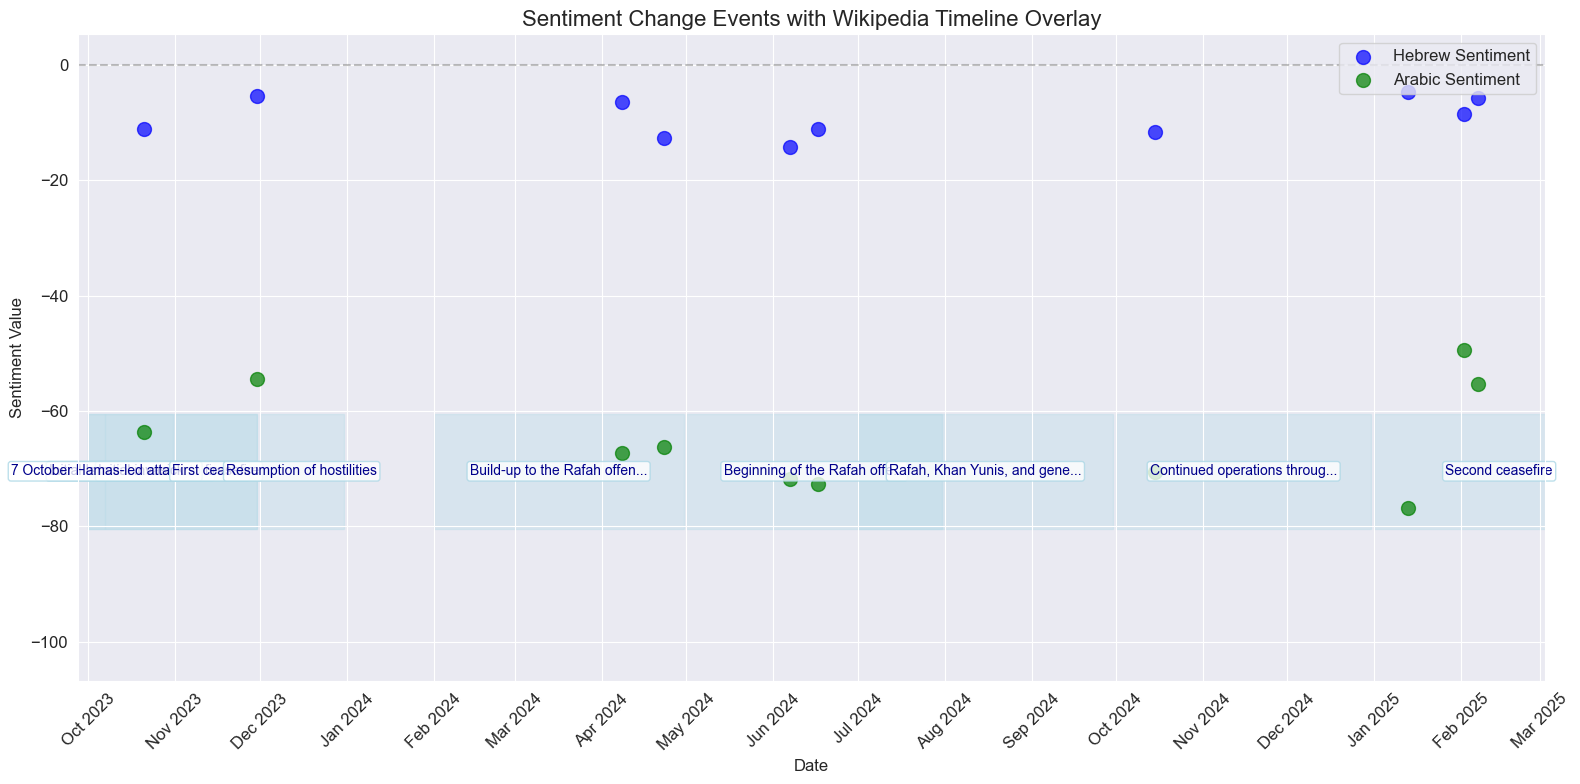

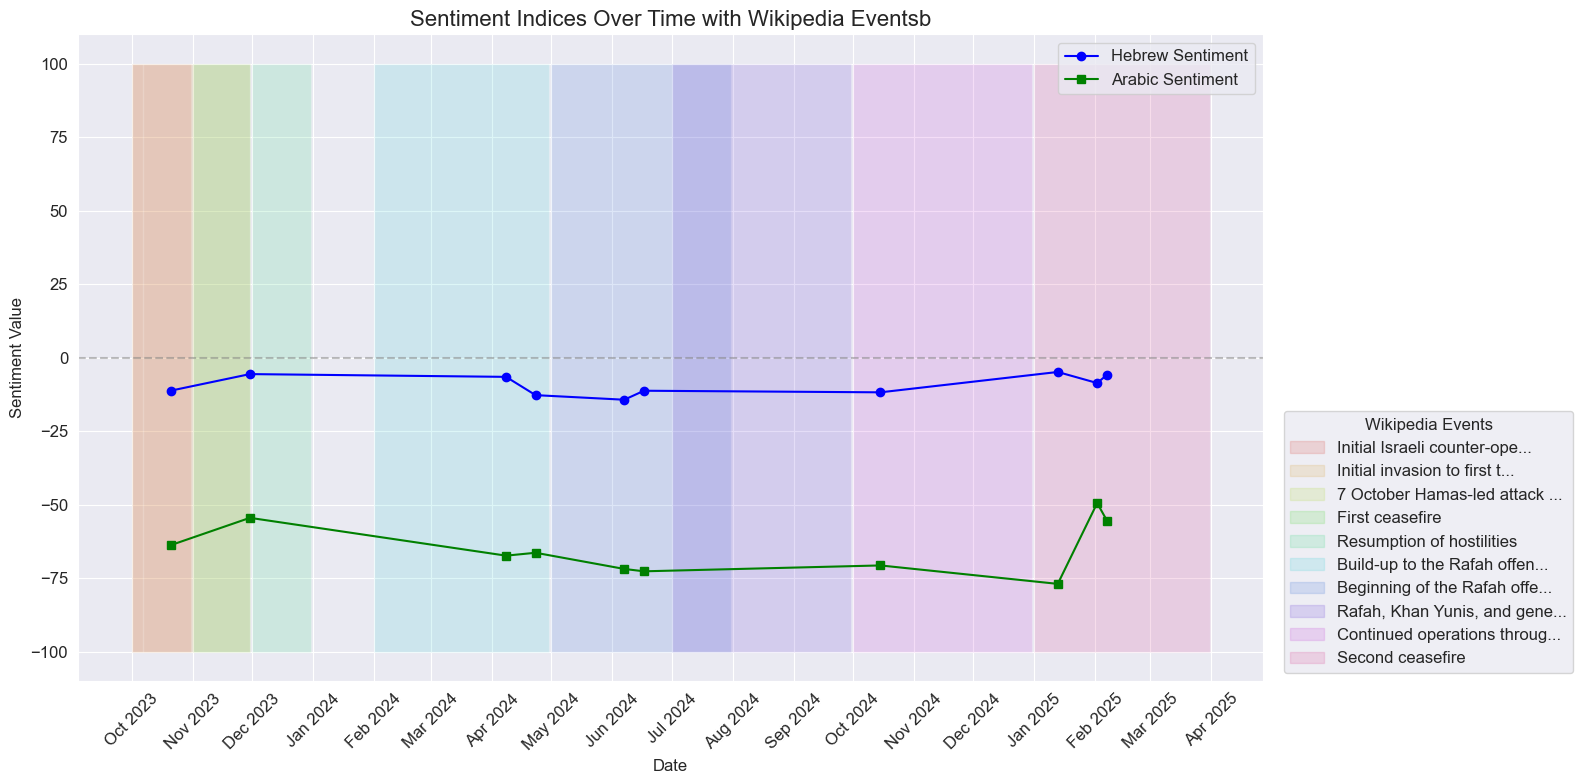

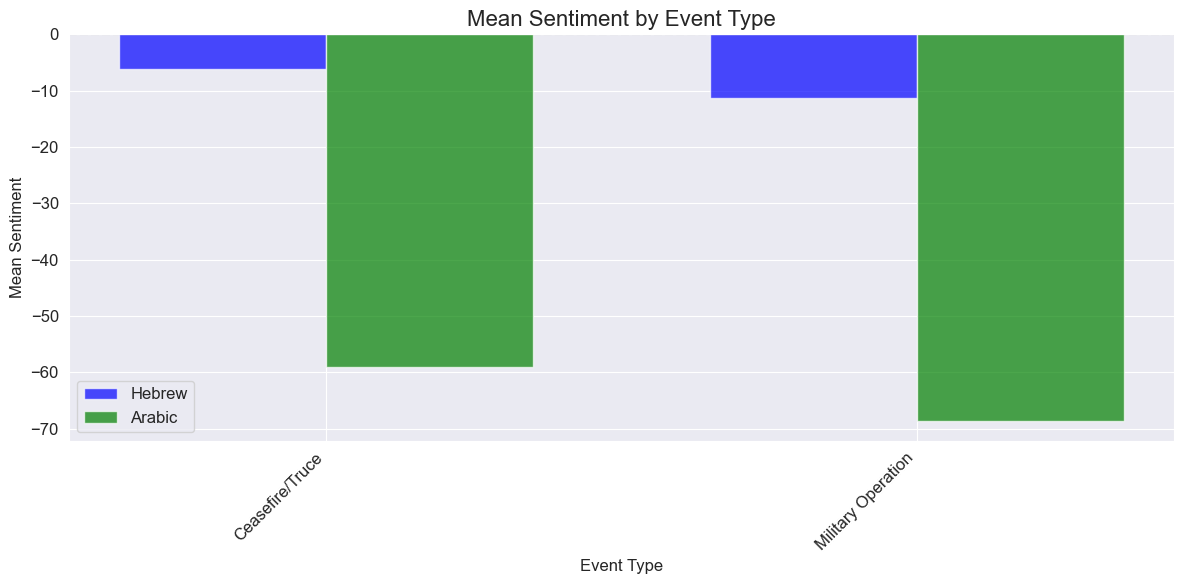

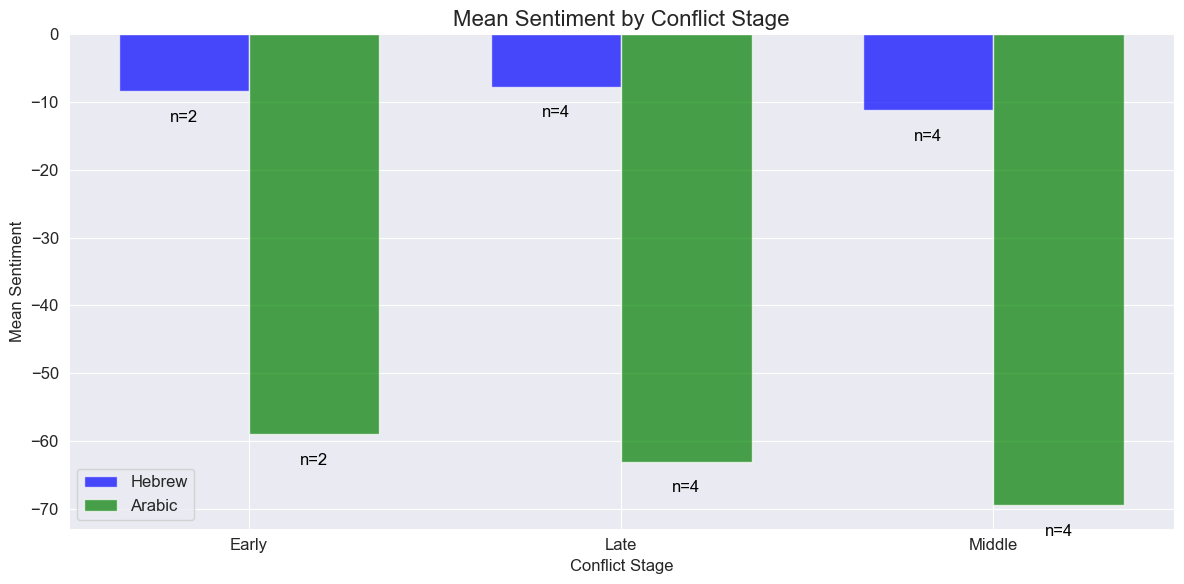

In [16]:
results = exploratory_analysis_visualization(
    integrated_data_path='../data/sentiment_events/integrated_events.csv',
    wiki_timeline_path='../data/wikipedia/wiki_time_periods.csv',
    output_path='../ARCHIVE/visualizations'
)

## Sentiment Indices Over Time with Wikipedia Events

In [32]:
def sentiment_timeline_visualization(integrated_data_path, wiki_timeline_path, output_path=None):
    """
    Create visualization for sentiment indices over time with Wikipedia events.

    Parameters:
    -----------
    integrated_data_path : str
        Path to the CSV file containing integrated sentiment and wiki events
    wiki_timeline_path : str
        Path to the CSV file containing preprocessed Wikipedia timeline
    output_path : str, optional
        Path to save visualization output, if None will display instead
    """
    # Load the integrated data and wiki timeline
    integrated_data = pd.read_csv(integrated_data_path)
    wiki_timeline = pd.read_csv(wiki_timeline_path)

    # Convert date columns to datetime
    integrated_data['date'] = pd.to_datetime(integrated_data['date'])
    wiki_timeline['start_date'] = pd.to_datetime(wiki_timeline['start_date'])
    wiki_timeline['end_date'] = pd.to_datetime(wiki_timeline['end_date'])

    # Sort data chronologically
    integrated_data = integrated_data.sort_values('date')
    wiki_timeline = wiki_timeline.sort_values('start_date')

    # Set larger font sizes for all elements
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    LARGE_SIZE = 18
    TITLE_SIZE = 20

    plt.rc('font', size=SMALL_SIZE)          # default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)     # x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)     # x tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)     # y tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)     # legend
    plt.rc('figure', titlesize=TITLE_SIZE)    # figure title

    # Create the Sentiment Index Temporal Plot with Wikipedia Periods
    fig, ax = plt.subplots(figsize=(18, 10))  # Increased figure size for better readability

    # Filter out the "7 October Hamas-led attack on Israel" event
    wiki_timeline = wiki_timeline[~wiki_timeline['title'].str.contains('7 October Hamas-led attack on Israel', case=False, na=False)]

    # Sort periods by start date and create a color palette
    wiki_timeline = wiki_timeline.sort_values('start_date')
    colors = sns.color_palette("hls", len(wiki_timeline))

    # Set fixed y-axis limits as requested
    y_min = -100
    y_max = 10

    # Add background shading for Wikipedia periods
    legend_handles = []
    for i, (_, period) in enumerate(wiki_timeline.iterrows()):
        # Draw a rectangle for each period
        rect = Rectangle((mdates.date2num(period['start_date']), y_min),
                        mdates.date2num(period['end_date']) - mdates.date2num(period['start_date']),
                        y_max - y_min,  # Use calculated height
                        facecolor=colors[i], alpha=0.2)
        ax.add_patch(rect)

        # Use the full title for the legend
        full_title = period['title'].strip()

        # Add a proxy artist for the legend
        legend_handles.append((plt.Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.2), full_title))

    # Plot Hebrew sentiment as a line with larger markers
    ax.plot(integrated_data['date'], integrated_data['hebrew_sentiment'],
            marker='o', markersize=8, linestyle='-', linewidth=2,
            color='blue', label='Hebrew Sentiment')

    # Plot Arabic sentiment as a line with larger markers
    ax.plot(integrated_data['date'], integrated_data['arabic_sentiment'],
            marker='s', markersize=8, linestyle='-', linewidth=2,
            color='green', label='Arabic Sentiment')

    # Add reference line at y=0
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

    # Format the x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')

    # Set y-axis limits
    ax.set_ylim(y_min, y_max)

    # Set labels and title
    ax.set_xlabel('Date', fontsize=LARGE_SIZE)
    ax.set_ylabel('Sentiment Value', fontsize=LARGE_SIZE)
    # ax.set_title('Sentiment Indices Over Time with Wikipedia Events', fontsize=TITLE_SIZE, pad=20)

    # Add legend for sentiment lines with larger size
    sentiment_legend = ax.legend(loc='upper right', fontsize=MEDIUM_SIZE)

    # Add the sentiment legend to the main plot
    ax.add_artist(sentiment_legend)

    # Add Wikipedia events legend to the right side of the plot
    # Create a box for the legend that's big enough for the full text
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])

    # Add second legend for Wiki events with full text
    second_legend = plt.legend(
        *zip(*legend_handles),
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        fontsize=MEDIUM_SIZE,
        title='Wikipedia Events',
        title_fontsize=LARGE_SIZE
    )

    plt.tight_layout()

    # Save or show the figure (only one figure now)
    if output_path:
        fig.savefig(f"{output_path}/sentiment_over_wiki_events.pdf", dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {output_path}/sentiment_temporal_plot.pdf")
    else:
        plt.show()

Visualization saved to ../figs/sentiment_temporal_plot.pdf


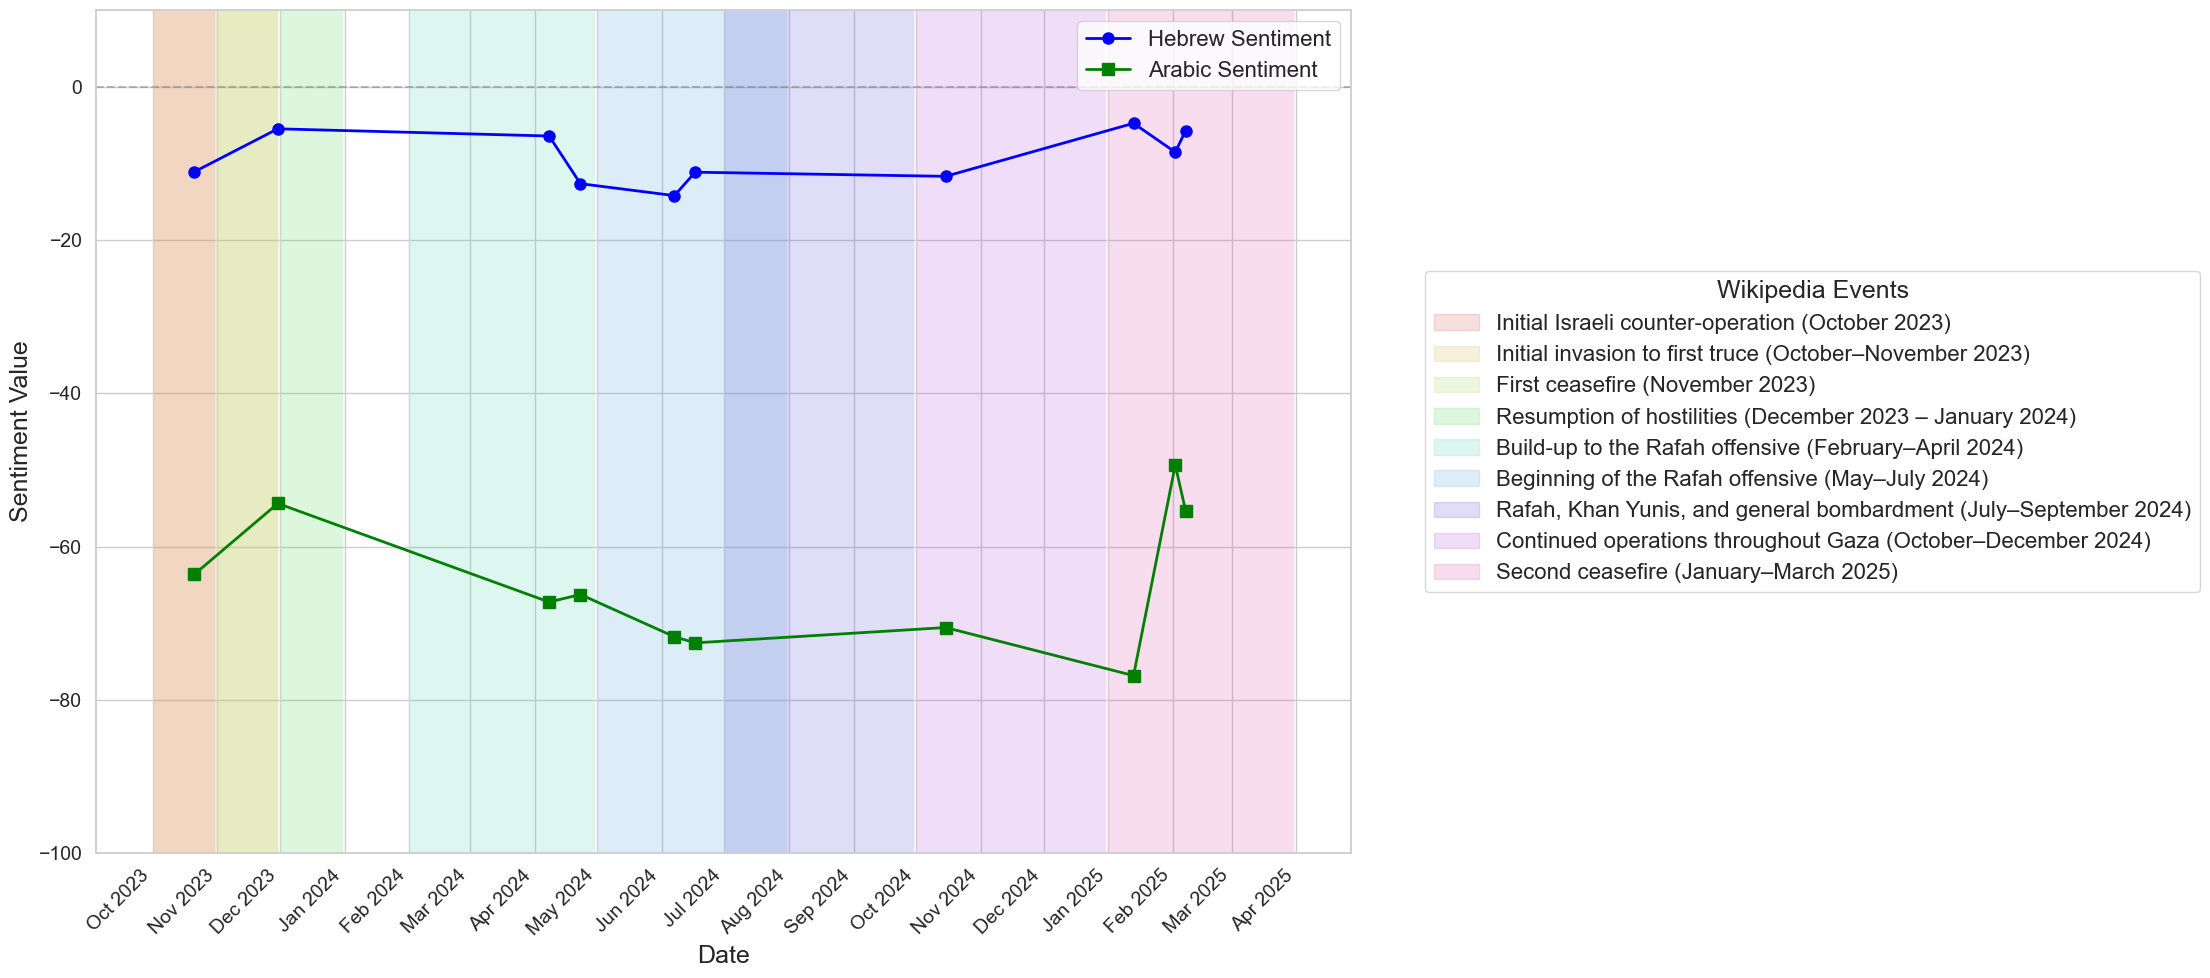

In [33]:
sentiment_timeline_visualization(integrated_data_path='../data/sentiment_events/integrated_events.csv',
                                 wiki_timeline_path='../data/wikipedia/wiki_time_periods.csv',
                                 output_path= '../figs')

# Quantitative Time Series Analysis

## Window-Based Analysis

In [19]:
def window_based_analysis(integrated_data_path, wiki_timeline_path, output_path=None):
    """
    Perform window-based analysis around Wikipedia-documented events to identify
    sentiment shifts before, during, and after these events.

    Parameters:
    -----------
    integrated_data_path : str
        Path to the CSV file containing integrated sentiment events
    wiki_timeline_path : str
        Path to the CSV file containing preprocessed Wikipedia timeline
    output_path : str, optional
        Path to save visualization outputs

    Returns:
    --------
    dict
        Results of the window-based analysis
    """
    # Load data
    integrated_data = pd.read_csv(integrated_data_path)
    wiki_events = pd.read_csv(wiki_timeline_path)

    # Convert dates to datetime
    integrated_data['date'] = pd.to_datetime(integrated_data['date'])
    wiki_events['start_date'] = pd.to_datetime(wiki_events['start_date'])
    wiki_events['end_date'] = pd.to_datetime(wiki_events['end_date'])

    # Sort by date
    integrated_data = integrated_data.sort_values('date')
    wiki_events = wiki_events.sort_values('start_date')

    # Create a date range for the entire period
    min_date = min(integrated_data['date'].min(), wiki_events['start_date'].min())
    max_date = max(integrated_data['date'].max(), wiki_events['end_date'].max())
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Create a daily time series dataframe
    daily_series = pd.DataFrame(index=date_range)
    daily_series.index.name = 'date'

    # Function to calculate window statistics around events
    def analyze_event_windows(event_row, window_size=7):
        """Analyze sentiment before, during, and after a Wikipedia event."""
        event_start = event_row['start_date']
        event_end = event_row['end_date']
        event_title = event_row['title']

        # Create time windows
        before_start = event_start - timedelta(days=window_size)
        before_end = event_start - timedelta(days=1)
        during_start = event_start
        during_end = event_end
        after_start = event_end + timedelta(days=1)
        after_end = event_end + timedelta(days=window_size)

        # Filter sentiment data for each window
        before_data = integrated_data[(integrated_data['date'] >= before_start) &
                                     (integrated_data['date'] <= before_end)]
        during_data = integrated_data[(integrated_data['date'] >= during_start) &
                                     (integrated_data['date'] <= during_end)]
        after_data = integrated_data[(integrated_data['date'] >= after_start) &
                                    (integrated_data['date'] <= after_end)]

        # Calculate metrics for Hebrew sentiment
        hebrew_before = before_data['hebrew_sentiment'].mean() if len(before_data) > 0 else np.nan
        hebrew_during = during_data['hebrew_sentiment'].mean() if len(during_data) > 0 else np.nan
        hebrew_after = after_data['hebrew_sentiment'].mean() if len(after_data) > 0 else np.nan

        # Calculate metrics for Arabic sentiment
        arabic_before = before_data['arabic_sentiment'].mean() if len(before_data) > 0 else np.nan
        arabic_during = during_data['arabic_sentiment'].mean() if len(during_data) > 0 else np.nan
        arabic_after = after_data['arabic_sentiment'].mean() if len(after_data) > 0 else np.nan

        # Calculate sentiment shifts
        hebrew_shift_during = hebrew_during - hebrew_before if not (np.isnan(hebrew_during) or np.isnan(hebrew_before)) else np.nan
        hebrew_shift_after = hebrew_after - hebrew_during if not (np.isnan(hebrew_after) or np.isnan(hebrew_during)) else np.nan

        arabic_shift_during = arabic_during - arabic_before if not (np.isnan(arabic_during) or np.isnan(arabic_before)) else np.nan
        arabic_shift_after = arabic_after - arabic_during if not (np.isnan(arabic_after) or np.isnan(arabic_during)) else np.nan

        # Determine significance of shifts using t-tests where possible
        hebrew_sig_during = None
        hebrew_sig_after = None
        arabic_sig_during = None
        arabic_sig_after = None

        if len(before_data) > 0 and len(during_data) > 0:
            try:
                _, hebrew_sig_during = stats.ttest_ind(before_data['hebrew_sentiment'], during_data['hebrew_sentiment'])
                _, arabic_sig_during = stats.ttest_ind(before_data['arabic_sentiment'], during_data['arabic_sentiment'])
            except:
                pass

        if len(during_data) > 0 and len(after_data) > 0:
            try:
                _, hebrew_sig_after = stats.ttest_ind(during_data['hebrew_sentiment'], after_data['hebrew_sentiment'])
                _, arabic_sig_after = stats.ttest_ind(during_data['arabic_sentiment'], after_data['arabic_sentiment'])
            except:
                pass

        # Compile results
        result = {
            'event': event_title,
            'window_size': window_size,
            'before_start': before_start,
            'before_end': before_end,
            'during_start': during_start,
            'during_end': during_end,
            'after_start': after_start,
            'after_end': after_end,
            'hebrew_before': hebrew_before,
            'hebrew_during': hebrew_during,
            'hebrew_after': hebrew_after,
            'arabic_before': arabic_before,
            'arabic_during': arabic_during,
            'arabic_after': arabic_after,
            'hebrew_shift_during': hebrew_shift_during,
            'hebrew_shift_after': hebrew_shift_after,
            'arabic_shift_during': arabic_shift_during,
            'arabic_shift_after': arabic_shift_after,
            'hebrew_sig_during': hebrew_sig_during,
            'hebrew_sig_after': hebrew_sig_after,
            'arabic_sig_during': arabic_sig_during,
            'arabic_sig_after': arabic_sig_after,
            'n_before': len(before_data),
            'n_during': len(during_data),
            'n_after': len(after_data)
        }

        return result

    # Analyze windows for each Wikipedia event
    window_results = []
    for _, event in wiki_events.iterrows():
        # Use different window sizes based on event duration
        event_duration = (event['end_date'] - event['start_date']).days + 1

        # For very short events, use 3-day windows
        if event_duration <= 3:
            window_size = 3
        # For medium length events, use 7-day windows
        elif event_duration <= 14:
            window_size = 7
        # For longer events, use 14-day windows
        else:
            window_size = 14

        result = analyze_event_windows(event, window_size)
        window_results.append(result)

    # Create a DataFrame with the results
    window_df = pd.DataFrame(window_results)

    # Calculate overall sentiment shifts for each language
    window_df['hebrew_net_shift'] = window_df['hebrew_after'] - window_df['hebrew_before']
    window_df['arabic_net_shift'] = window_df['arabic_after'] - window_df['arabic_before']

    # Identify significant shifts (p < 0.05)
    window_df['hebrew_sig_during_flag'] = (window_df['hebrew_sig_during'] < 0.05) if 'hebrew_sig_during' in window_df.columns else False
    window_df['hebrew_sig_after_flag'] = (window_df['hebrew_sig_after'] < 0.05) if 'hebrew_sig_after' in window_df.columns else False
    window_df['arabic_sig_during_flag'] = (window_df['arabic_sig_during'] < 0.05) if 'arabic_sig_during' in window_df.columns else False
    window_df['arabic_sig_after_flag'] = (window_df['arabic_sig_after'] < 0.05) if 'arabic_sig_after' in window_df.columns else False

    # Visualize the sentiment shifts around events
    plt.figure(figsize=(14, 8))

    # Plot Hebrew sentiment shifts
    plt.subplot(2, 1, 1)
    for i, row in window_df.iterrows():
        # Set colors based on significance
        during_color = 'darkblue' if row.get('hebrew_sig_during_flag', False) else 'lightblue'
        after_color = 'darkblue' if row.get('hebrew_sig_after_flag', False) else 'lightblue'

        # Plot bars for shifts
        plt.bar(i*3, row['hebrew_shift_during'], width=0.8, color=during_color, label='During' if i==0 else "")
        plt.bar(i*3+1, row['hebrew_shift_after'], width=0.8, color=after_color, label='After' if i==0 else "")

    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.title('Hebrew Sentiment Shifts Around Wikipedia Events')
    plt.ylabel('Sentiment Shift')
    plt.xticks([i*3+0.5 for i in range(len(window_df))], window_df['event'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Plot Arabic sentiment shifts
    plt.subplot(2, 1, 2)
    for i, row in window_df.iterrows():
        # Set colors based on significance
        during_color = 'darkgreen' if row.get('arabic_sig_during_flag', False) else 'lightgreen'
        after_color = 'darkgreen' if row.get('arabic_sig_after_flag', False) else 'lightgreen'

        # Plot bars for shifts
        plt.bar(i*3, row['arabic_shift_during'], width=0.8, color=during_color, label='During' if i==0 else "")
        plt.bar(i*3+1, row['arabic_shift_after'], width=0.8, color=after_color, label='After' if i==0 else "")

    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.title('Arabic Sentiment Shifts Around Wikipedia Events')
    plt.ylabel('Sentiment Shift')
    plt.xticks([i*3+0.5 for i in range(len(window_df))], window_df['event'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/sentiment_shifts_around_events.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # Print summary of significant shifts
    print("Summary of Significant Sentiment Shifts:")
    print("-" * 80)

    for _, row in window_df.iterrows():
        event = row['event']

        # Check for significant shifts in Hebrew sentiment
        if row.get('hebrew_sig_during_flag', False):
            print(f"Hebrew sentiment showed significant shift DURING '{event}':")
            print(f"  Before: {row['hebrew_before']:.2f} → During: {row['hebrew_during']:.2f} (Δ = {row['hebrew_shift_during']:.2f})")

        if row.get('hebrew_sig_after_flag', False):
            print(f"Hebrew sentiment showed significant shift AFTER '{event}':")
            print(f"  During: {row['hebrew_during']:.2f} → After: {row['hebrew_after']:.2f} (Δ = {row['hebrew_shift_after']:.2f})")

        # Check for significant shifts in Arabic sentiment
        if row.get('arabic_sig_during_flag', False):
            print(f"Arabic sentiment showed significant shift DURING '{event}':")
            print(f"  Before: {row['arabic_before']:.2f} → During: {row['arabic_during']:.2f} (Δ = {row['arabic_shift_during']:.2f})")

        if row.get('arabic_sig_after_flag', False):
            print(f"Arabic sentiment showed significant shift AFTER '{event}':")
            print(f"  During: {row['arabic_during']:.2f} → After: {row['arabic_after']:.2f} (Δ = {row['arabic_shift_after']:.2f})")

        if (row.get('hebrew_sig_during_flag', False) or row.get('hebrew_sig_after_flag', False) or
            row.get('arabic_sig_during_flag', False) or row.get('arabic_sig_after_flag', False)):
            print("-" * 40)

    return window_df


Summary of Significant Sentiment Shifts:
--------------------------------------------------------------------------------


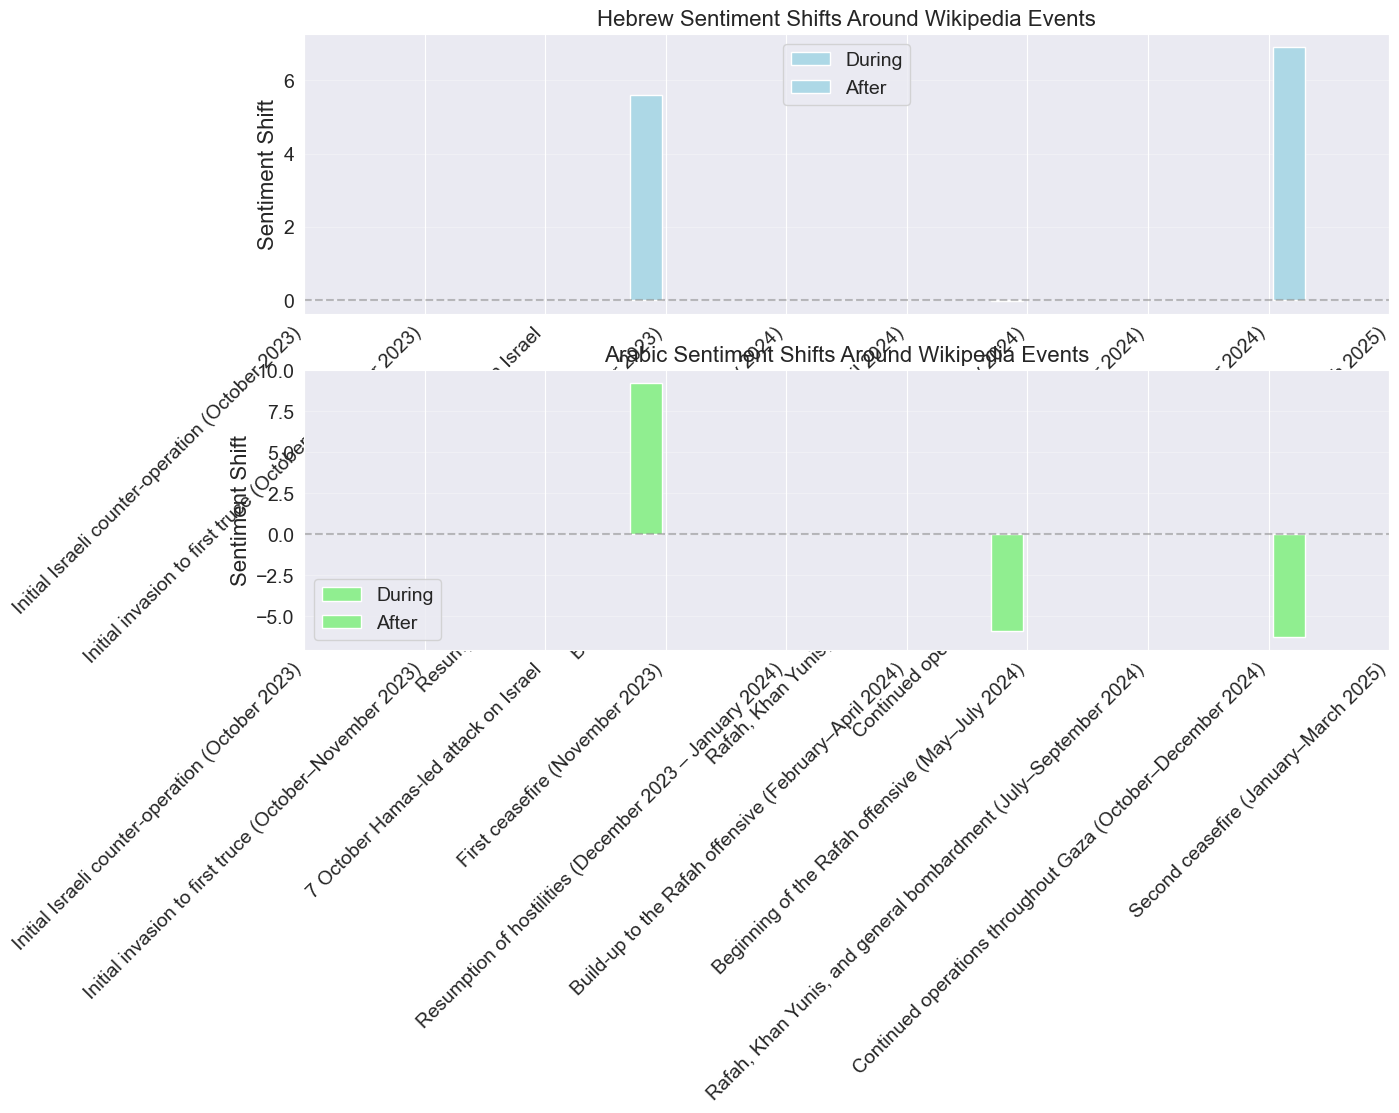

In [20]:
# Perform window-based analysis
window_results = window_based_analysis(
    integrated_data_path='../data/sentiment_events/integrated_events.csv',
    wiki_timeline_path='../data/wikipedia/wiki_time_periods.csv',
    output_path='../ARCHIVE/visualizations'
)

## Cross-Correlation Function (CCF) Analysis

In [21]:
def cross_correlation_analysis(integrated_data_path, wiki_timeline_path, output_path=None):
    """
    Perform cross-correlation analysis between sentiment time series and Wikipedia events.

    Parameters:
    -----------
    integrated_data_path : str
        Path to the CSV file containing integrated sentiment events
    wiki_timeline_path : str
        Path to the CSV file containing preprocessed Wikipedia timeline
    output_path : str, optional
        Path to save visualization outputs

    Returns:
    --------
    dict
        Results of the cross-correlation analysis
    """
    # Load data
    integrated_data = pd.read_csv(integrated_data_path)
    wiki_events = pd.read_csv(wiki_timeline_path)

    # Convert dates to datetime
    integrated_data['date'] = pd.to_datetime(integrated_data['date'])
    wiki_events['start_date'] = pd.to_datetime(wiki_events['start_date'])
    wiki_events['end_date'] = pd.to_datetime(wiki_events['end_date'])

    # Create a date range covering the entire study period (daily frequency)
    min_date = min(integrated_data['date'].min(), wiki_events['start_date'].min())
    max_date = max(integrated_data['date'].max(), wiki_events['end_date'].max())
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Create a daily time series dataframe
    daily_df = pd.DataFrame(index=full_date_range)
    daily_df.index.name = 'date'

    # Create a binary indicator for Wikipedia events (1 if day falls within an event, 0 otherwise)
    daily_df['wiki_event'] = 0

    for _, event in wiki_events.iterrows():
        event_dates = pd.date_range(start=event['start_date'], end=event['end_date'], freq='D')
        daily_df.loc[event_dates, 'wiki_event'] = 1

    # Interpolate sentiment values for each day
    # First, create a temporary DataFrame with sentiment values on the dates we have
    temp_hebrew = pd.DataFrame({'date': integrated_data['date'],
                              'sentiment': integrated_data['hebrew_sentiment']})
    temp_arabic = pd.DataFrame({'date': integrated_data['date'],
                              'sentiment': integrated_data['arabic_sentiment']})

    # Group by date to handle multiple events on the same day (take mean)
    temp_hebrew = temp_hebrew.groupby('date')['sentiment'].mean().reset_index()
    temp_arabic = temp_arabic.groupby('date')['sentiment'].mean().reset_index()

    # Set the date as index
    temp_hebrew.set_index('date', inplace=True)
    temp_arabic.set_index('date', inplace=True)

    # Merge with the daily dataframe
    daily_df['hebrew_sentiment'] = temp_hebrew['sentiment']
    daily_df['arabic_sentiment'] = temp_arabic['sentiment']

    # Interpolate missing values - use linear interpolation for reasonable gaps
    # and forward/backward fill for longer gaps
    daily_df['hebrew_sentiment'] = daily_df['hebrew_sentiment'].interpolate(method='linear', limit=7)
    daily_df['hebrew_sentiment'] = daily_df['hebrew_sentiment'].fillna(method='ffill').fillna(method='bfill')

    daily_df['arabic_sentiment'] = daily_df['arabic_sentiment'].interpolate(method='linear', limit=7)
    daily_df['arabic_sentiment'] = daily_df['arabic_sentiment'].fillna(method='ffill').fillna(method='bfill')

    # Ensure we have no NaN values left
    daily_df = daily_df.dropna()

    # Prepare series for cross-correlation
    wiki_series = daily_df['wiki_event'].values
    hebrew_series = daily_df['hebrew_sentiment'].values
    arabic_series = daily_df['arabic_sentiment'].values

    # Standardize series for better comparison
    wiki_series_std = (wiki_series - wiki_series.mean()) / wiki_series.std()
    hebrew_series_std = (hebrew_series - hebrew_series.mean()) / hebrew_series.std()
    arabic_series_std = (arabic_series - arabic_series.mean()) / arabic_series.std()

    # Calculate cross-correlation function
    # For Hebrew sentiment
    max_lag = min(30, len(daily_df) // 2)  # Maximum lag to consider (30 days or half the series length)

    # Compute CCF with statsmodels (this handles proper normalization)
    hebrew_ccf = sm.tsa.stattools.ccf(hebrew_series_std, wiki_series_std, adjusted=False)
    arabic_ccf = sm.tsa.stattools.ccf(arabic_series_std, wiki_series_std, adjusted=False)

    # Only keep the lags we're interested in
    lags = np.arange(-max_lag, max_lag + 1)
    hebrew_ccf = hebrew_ccf[len(hebrew_ccf)//2 - max_lag:len(hebrew_ccf)//2 + max_lag + 1]
    arabic_ccf = arabic_ccf[len(arabic_ccf)//2 - max_lag:len(arabic_ccf)//2 + max_lag + 1]

    # Find maximum correlation and corresponding lag
    hebrew_max_corr_idx = np.argmax(np.abs(hebrew_ccf))
    hebrew_max_corr = hebrew_ccf[hebrew_max_corr_idx]
    hebrew_max_lag = lags[hebrew_max_corr_idx]

    arabic_max_corr_idx = np.argmax(np.abs(arabic_ccf))
    arabic_max_corr = arabic_ccf[arabic_max_corr_idx]
    arabic_max_lag = lags[arabic_max_corr_idx]

    # Determine significance thresholds (assuming independence)
    significance_level = 0.05
    n = len(daily_df)
    critical_value = stats.norm.ppf(1 - significance_level/2) / np.sqrt(n)

    # Create plot for cross-correlation functions
    plt.figure(figsize=(14, 10))

    # Plot Hebrew CCF
    plt.subplot(2, 1, 1)
    plt.bar(lags, hebrew_ccf, width=0.8, color='blue', alpha=0.7)
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.axhline(y=critical_value, color='red', linestyle='--', alpha=0.7, label=f'5% Significance ({critical_value:.3f})')
    plt.axhline(y=-critical_value, color='red', linestyle='--', alpha=0.7)

    # Mark the maximum correlation
    plt.plot(hebrew_max_lag, hebrew_max_corr, 'ro', markersize=10)
    plt.annotate(f'Max at lag {hebrew_max_lag}: {hebrew_max_corr:.3f}',
                xy=(hebrew_max_lag, hebrew_max_corr),
                xytext=(hebrew_max_lag + 2, hebrew_max_corr + 0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
                bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))

    plt.title('Cross-correlation: Hebrew Sentiment and Wikipedia Events')
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(alpha=0.3)

    # Plot Arabic CCF
    plt.subplot(2, 1, 2)
    plt.bar(lags, arabic_ccf, width=0.8, color='green', alpha=0.7)
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.axhline(y=critical_value, color='red', linestyle='--', alpha=0.7, label=f'5% Significance ({critical_value:.3f})')
    plt.axhline(y=-critical_value, color='red', linestyle='--', alpha=0.7)

    # Mark the maximum correlation
    plt.plot(arabic_max_lag, arabic_max_corr, 'ro', markersize=10)
    plt.annotate(f'Max at lag {arabic_max_lag}: {arabic_max_corr:.3f}',
                xy=(arabic_max_lag, arabic_max_corr),
                xytext=(arabic_max_lag + 2, arabic_max_corr + 0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
                bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))

    plt.title('Cross-correlation: Arabic Sentiment and Wikipedia Events')
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/cross_correlation_analysis.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # Print interpretation of results
    print("\nCross-Correlation Analysis Results:")
    print("-" * 80)

    # Interpret Hebrew results
    print("Hebrew Sentiment and Wikipedia Events:")
    print(f"  Maximum correlation: {hebrew_max_corr:.3f} at lag {hebrew_max_lag} days")

    if abs(hebrew_max_corr) > critical_value:
        direction = "positive" if hebrew_max_corr > 0 else "negative"
        if hebrew_max_lag < 0:
            print(f"  Significant {direction} correlation suggests Hebrew sentiment changes PRECEDE")
            print(f"  Wikipedia events by {abs(hebrew_max_lag)} days")
        elif hebrew_max_lag > 0:
            print(f"  Significant {direction} correlation suggests Hebrew sentiment changes FOLLOW")
            print(f"  Wikipedia events by {hebrew_max_lag} days")
        else:
            print(f"  Significant {direction} correlation suggests Hebrew sentiment changes occur")
            print("  SIMULTANEOUSLY with Wikipedia events")
    else:
        print("  No significant correlation detected between Hebrew sentiment and Wikipedia events")

    # Interpret Arabic results
    print("\nArabic Sentiment and Wikipedia Events:")
    print(f"  Maximum correlation: {arabic_max_corr:.3f} at lag {arabic_max_lag} days")

    if abs(arabic_max_corr) > critical_value:
        direction = "positive" if arabic_max_corr > 0 else "negative"
        if arabic_max_lag < 0:
            print(f"  Significant {direction} correlation suggests Arabic sentiment changes PRECEDE")
            print(f"  Wikipedia events by {abs(arabic_max_lag)} days")
        elif arabic_max_lag > 0:
            print(f"  Significant {direction} correlation suggests Arabic sentiment changes FOLLOW")
            print(f"  Wikipedia events by {arabic_max_lag} days")
        else:
            print(f"  Significant {direction} correlation suggests Arabic sentiment changes occur")
            print("  SIMULTANEOUSLY with Wikipedia events")
    else:
        print("  No significant correlation detected between Arabic sentiment and Wikipedia events")

    # Return results
    results = {
        'daily_timeseries': daily_df,
        'hebrew_ccf': {
            'lags': lags,
            'values': hebrew_ccf,
            'max_lag': hebrew_max_lag,
            'max_corr': hebrew_max_corr,
            'critical_value': critical_value,
            'significant': abs(hebrew_max_corr) > critical_value
        },
        'arabic_ccf': {
            'lags': lags,
            'values': arabic_ccf,
            'max_lag': arabic_max_lag,
            'max_corr': arabic_max_corr,
            'critical_value': critical_value,
            'significant': abs(arabic_max_corr) > critical_value
        }
    }

    return results


Cross-Correlation Analysis Results:
--------------------------------------------------------------------------------
Hebrew Sentiment and Wikipedia Events:
  Maximum correlation: 0.164 at lag 14 days
  Significant positive correlation suggests Hebrew sentiment changes FOLLOW
  Wikipedia events by 14 days

Arabic Sentiment and Wikipedia Events:
  Maximum correlation: 0.196 at lag -17 days
  Significant positive correlation suggests Arabic sentiment changes PRECEDE
  Wikipedia events by 17 days


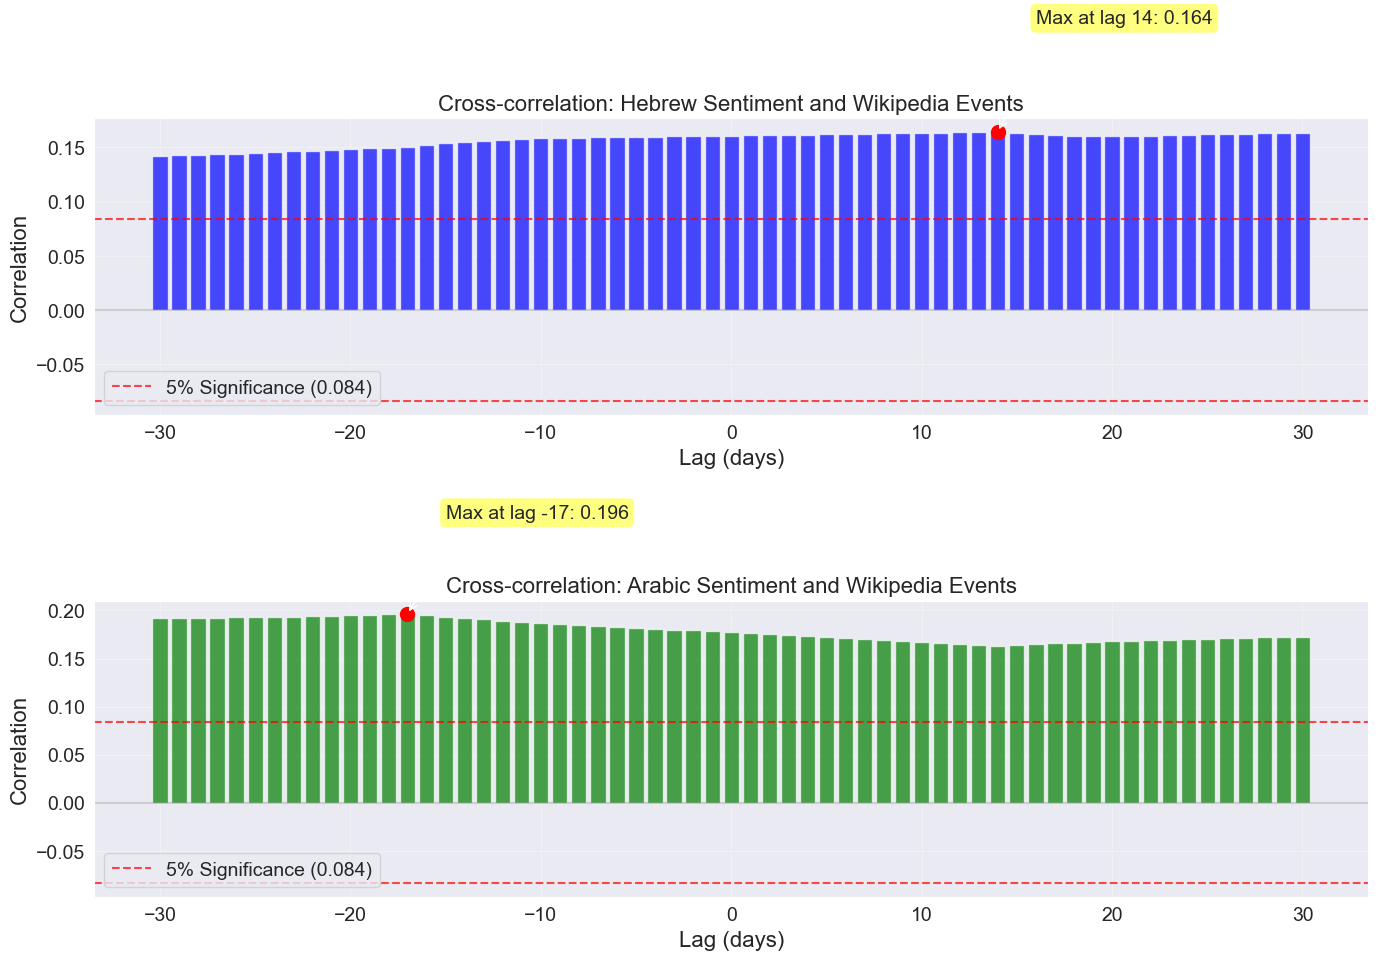

In [22]:
# Perform cross-correlation analysis
ccf_results = cross_correlation_analysis(
integrated_data_path='../data/sentiment_events/integrated_events.csv',
    wiki_timeline_path='../data/wikipedia/wiki_time_periods.csv',
    output_path='../ARCHIVE/visualizations'
)

# Statistical Validation

In [23]:
def create_daily_timeseries(integrated_data_path, wiki_timeline_path):
    """
    Create a daily timeseries dataframe with sentiment values and event flags.

    Parameters:
    -----------
    integrated_data_path : str
        Path to the CSV file containing integrated sentiment events
    wiki_timeline_path : str
        Path to the CSV file containing preprocessed Wikipedia timeline

    Returns:
    --------
    pandas.DataFrame
        Daily timeseries with sentiment values and event flags
    """
    # Load data
    integrated_data = pd.read_csv(integrated_data_path)
    wiki_events = pd.read_csv(wiki_timeline_path)

    # Print shapes to help debugging
    print(f"Loaded integrated data shape: {integrated_data.shape}")
    print(f"Loaded wiki events shape: {wiki_events.shape}")

    # Convert dates to datetime
    integrated_data['date'] = pd.to_datetime(integrated_data['date'])
    wiki_events['start_date'] = pd.to_datetime(wiki_events['start_date'])
    wiki_events['end_date'] = pd.to_datetime(wiki_events['end_date'])

    # Create a date range covering the entire study period (daily frequency)
    min_date = min(integrated_data['date'].min(), wiki_events['start_date'].min())
    max_date = max(integrated_data['date'].max(), wiki_events['end_date'].max())
    print(f"Date range: {min_date} to {max_date}")
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Create a daily time series dataframe
    daily_df = pd.DataFrame(index=full_date_range)
    daily_df.index.name = 'date'

    # Create a binary indicator for any Wikipedia event (1 if day falls within an event, 0 otherwise)
    daily_df['any_event'] = 0

    # Check if 'event_type' column exists in wiki_events
    if 'event_type' not in wiki_events.columns:
        print("Warning: 'event_type' column not found in wiki_events. Using 'title' instead.")
        # Create a simple event type based on title keywords
        def extract_event_type(title):
            title_lower = str(title).lower()
            if 'ceasefire' in title_lower or 'truce' in title_lower:
                return 'Ceasefire_Truce'
            elif 'attack' in title_lower:
                return 'Attack'
            elif 'invasion' in title_lower or 'offensive' in title_lower:
                return 'Military_Operation'
            elif 'operation' in title_lower:
                return 'Military_Operation'
            elif 'bombardment' in title_lower:
                return 'Bombardment'
            else:
                return 'Other'

        wiki_events['event_type'] = wiki_events['title'].apply(extract_event_type)

    # Add event type indicators (one-hot encoding)
    event_types = []
    for _, event in wiki_events.iterrows():
        event_type = event.get('event_type', 'Other')
        if not pd.isna(event_type) and event_type not in event_types:
            event_types.append(event_type)
            type_col = f'event_{event_type.lower().replace("/", "_").replace(" ", "_")}'
            daily_df[type_col] = 0

    # Print detected event types for debugging
    print(f"Detected event types: {event_types}")

    # Fill in event indicators
    for _, event in wiki_events.iterrows():
        event_dates = pd.date_range(start=event['start_date'], end=event['end_date'], freq='D')
        daily_df.loc[event_dates, 'any_event'] = 1

        # Also set the specific event type flag
        event_type = event.get('event_type', 'Other')
        if not pd.isna(event_type):
            type_col = f'event_{event_type.lower().replace("/", "_").replace(" ", "_")}'
            if type_col in daily_df.columns:
                daily_df.loc[event_dates, type_col] = 1
            else:
                print(f"Warning: Column {type_col} not found in dataframe")

    # Process sentiment data
    # Check if sentiment columns exist
    if 'hebrew_sentiment' not in integrated_data.columns or 'arabic_sentiment' not in integrated_data.columns:
        raise ValueError("Required sentiment columns not found in integrated data")

    # Group by date to handle multiple events on the same day (take mean)
    sentiment_by_date = integrated_data.groupby('date').agg({
        'hebrew_sentiment': 'mean',
        'arabic_sentiment': 'mean'
    }).reset_index()

    # Set the date as index
    sentiment_by_date.set_index('date', inplace=True)

    # Merge with the daily dataframe
    daily_df = daily_df.join(sentiment_by_date)

    # Interpolate missing values - use linear interpolation for reasonable gaps
    # and forward/backward fill for longer gaps
    daily_df['hebrew_sentiment'] = daily_df['hebrew_sentiment'].interpolate(method='linear', limit=7)
    daily_df['hebrew_sentiment'] = daily_df['hebrew_sentiment'].fillna(method='ffill').fillna(method='bfill')

    daily_df['arabic_sentiment'] = daily_df['arabic_sentiment'].interpolate(method='linear', limit=7)
    daily_df['arabic_sentiment'] = daily_df['arabic_sentiment'].fillna(method='ffill').fillna(method='bfill')

    # Check for any remaining NaN values
    missing_count = daily_df.isna().sum().sum()
    if missing_count > 0:
        print(f"Warning: {missing_count} missing values remain after interpolation")

    # Ensure we have no NaN values left
    daily_df = daily_df.dropna()

    # Reset index to have date as a column
    daily_df = daily_df.reset_index()

    # Add dummy variables for time periods (months) - create numeric dummy variables
    daily_df['month'] = daily_df['date'].dt.month  # Use numeric month value
    month_dummies = pd.get_dummies(daily_df['month'], prefix='month', drop_first=True)

    # Ensure month_dummies is not empty
    if month_dummies.empty:
        print("Warning: No month dummies created, adding placeholders")
        # Add placeholder month columns
        for i in range(2, 13):  # Months 2-12 (since we drop the first)
            month_dummies[f'month_{i}'] = 0

    daily_df = pd.concat([daily_df, month_dummies], axis=1)

    # Ensure all columns have numeric data types
    for col in daily_df.columns:
        if col != 'date':  # Keep date as datetime
            try:
                daily_df[col] = pd.to_numeric(daily_df[col])
            except:
                print(f"Warning: Could not convert column {col} to numeric")

    print(f"Final daily timeseries shape: {daily_df.shape}")

    return daily_df

def hypothesis_testing(daily_df, output_path=None):
    """
    Perform hypothesis testing to compare sentiment during events vs. non-events.

    Parameters:
    -----------
    daily_df : pandas.DataFrame
        Daily timeseries with sentiment values and event flags
    output_path : str, optional
        Path to save visualization outputs

    Returns:
    --------
    dict
        Results of hypothesis testing
    """
    # Set plotting style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Initialize results dictionary
    results = {
        'hebrew': {},
        'arabic': {}
    }

    # 1. T-test: Compare sentiment during events vs. non-events
    # Hebrew sentiment
    hebrew_event = daily_df[daily_df['any_event'] == 1]['hebrew_sentiment']
    hebrew_no_event = daily_df[daily_df['any_event'] == 0]['hebrew_sentiment']

    hebrew_ttest = stats.ttest_ind(hebrew_event, hebrew_no_event)
    results['hebrew']['ttest'] = {
        'statistic': hebrew_ttest.statistic,
        'pvalue': hebrew_ttest.pvalue,
        'significant': hebrew_ttest.pvalue < 0.05,
        'event_mean': hebrew_event.mean(),
        'no_event_mean': hebrew_no_event.mean(),
        'difference': hebrew_event.mean() - hebrew_no_event.mean()
    }

    # Arabic sentiment
    arabic_event = daily_df[daily_df['any_event'] == 1]['arabic_sentiment']
    arabic_no_event = daily_df[daily_df['any_event'] == 0]['arabic_sentiment']

    arabic_ttest = stats.ttest_ind(arabic_event, arabic_no_event)
    results['arabic']['ttest'] = {
        'statistic': arabic_ttest.statistic,
        'pvalue': arabic_ttest.pvalue,
        'significant': arabic_ttest.pvalue < 0.05,
        'event_mean': arabic_event.mean(),
        'no_event_mean': arabic_no_event.mean(),
        'difference': arabic_event.mean() - arabic_no_event.mean()
    }

    # Create box plots to visualize the differences
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='any_event', y='hebrew_sentiment', data=daily_df)
    plt.title(f'Hebrew Sentiment: Events vs. No Events\np={hebrew_ttest.pvalue:.4f}')
    plt.xlabel('Event Occurred')
    plt.ylabel('Sentiment')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='any_event', y='arabic_sentiment', data=daily_df)
    plt.title(f'Arabic Sentiment: Events vs. No Events\np={arabic_ttest.pvalue:.4f}')
    plt.xlabel('Event Occurred')
    plt.ylabel('Sentiment')

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/sentiment_events_boxplot.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # 2. ANOVA: Compare sentiment across different event types
    # First, create a categorical event type variable
    daily_df['event_category'] = 'No Event'
    event_type_cols = [col for col in daily_df.columns if col.startswith('event_') and col != 'any_event']

    for col in event_type_cols:
        event_name = col.replace('event_', '').replace('_', '/').title()
        daily_df.loc[daily_df[col] == 1, 'event_category'] = event_name

    # Hebrew sentiment ANOVA
    hebrew_anova_groups = [daily_df[daily_df['event_category'] == cat]['hebrew_sentiment']
                          for cat in daily_df['event_category'].unique()]

    try:
        hebrew_anova = stats.f_oneway(*hebrew_anova_groups)
        results['hebrew']['anova'] = {
            'statistic': hebrew_anova.statistic,
            'pvalue': hebrew_anova.pvalue,
            'significant': hebrew_anova.pvalue < 0.05
        }
    except:
        results['hebrew']['anova'] = {
            'statistic': None,
            'pvalue': None,
            'significant': False,
            'error': 'Could not perform ANOVA (possibly due to insufficient data in some groups)'
        }

    # Arabic sentiment ANOVA
    arabic_anova_groups = [daily_df[daily_df['event_category'] == cat]['arabic_sentiment']
                          for cat in daily_df['event_category'].unique()]

    try:
        arabic_anova = stats.f_oneway(*arabic_anova_groups)
        results['arabic']['anova'] = {
            'statistic': arabic_anova.statistic,
            'pvalue': arabic_anova.pvalue,
            'significant': arabic_anova.pvalue < 0.05
        }
    except:
        results['arabic']['anova'] = {
            'statistic': None,
            'pvalue': None,
            'significant': False,
            'error': 'Could not perform ANOVA (possibly due to insufficient data in some groups)'
        }

    # Create box plots to visualize sentiment by event type
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 1, 1)
    order = daily_df.groupby('event_category')['hebrew_sentiment'].mean().sort_values().index
    sns.boxplot(x='event_category', y='hebrew_sentiment', data=daily_df, order=order)
    plt.title('Hebrew Sentiment by Event Type')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Sentiment')

    # Add p-value annotation if ANOVA was successful
    if 'error' not in results['hebrew']['anova']:
        plt.annotate(f"ANOVA p-value: {results['hebrew']['anova']['pvalue']:.4f}",
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.subplot(2, 1, 2)
    order = daily_df.groupby('event_category')['arabic_sentiment'].mean().sort_values().index
    sns.boxplot(x='event_category', y='arabic_sentiment', data=daily_df, order=order)
    plt.title('Arabic Sentiment by Event Type')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Sentiment')

    # Add p-value annotation if ANOVA was successful
    if 'error' not in results['arabic']['anova']:
        plt.annotate(f"ANOVA p-value: {results['arabic']['anova']['pvalue']:.4f}",
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/sentiment_by_event_type.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # Print hypothesis testing results
    print("Hypothesis Testing Results:")
    print("-" * 80)

    # Hebrew T-test results
    print("\nHebrew Sentiment - Events vs. No Events (T-test):")
    print(f"  T-statistic: {results['hebrew']['ttest']['statistic']:.4f}")
    print(f"  p-value: {results['hebrew']['ttest']['pvalue']:.4f}")
    if results['hebrew']['ttest']['significant']:
        print(f"  SIGNIFICANT DIFFERENCE DETECTED (p < 0.05)")
    else:
        print(f"  No significant difference detected")
    print(f"  Mean during events: {results['hebrew']['ttest']['event_mean']:.4f}")
    print(f"  Mean during non-events: {results['hebrew']['ttest']['no_event_mean']:.4f}")
    print(f"  Difference: {results['hebrew']['ttest']['difference']:.4f}")

    # Arabic T-test results
    print("\nArabic Sentiment - Events vs. No Events (T-test):")
    print(f"  T-statistic: {results['arabic']['ttest']['statistic']:.4f}")
    print(f"  p-value: {results['arabic']['ttest']['pvalue']:.4f}")
    if results['arabic']['ttest']['significant']:
        print(f"  SIGNIFICANT DIFFERENCE DETECTED (p < 0.05)")
    else:
        print(f"  No significant difference detected")
    print(f"  Mean during events: {results['arabic']['ttest']['event_mean']:.4f}")
    print(f"  Mean during non-events: {results['arabic']['ttest']['no_event_mean']:.4f}")
    print(f"  Difference: {results['arabic']['ttest']['difference']:.4f}")

    # Hebrew ANOVA results
    print("\nHebrew Sentiment - Across Event Types (ANOVA):")
    if 'error' not in results['hebrew']['anova']:
        print(f"  F-statistic: {results['hebrew']['anova']['statistic']:.4f}")
        print(f"  p-value: {results['hebrew']['anova']['pvalue']:.4f}")
        if results['hebrew']['anova']['significant']:
            print(f"  SIGNIFICANT DIFFERENCES DETECTED ACROSS EVENT TYPES (p < 0.05)")
        else:
            print(f"  No significant differences detected across event types")
    else:
        print(f"  {results['hebrew']['anova']['error']}")

    # Arabic ANOVA results
    print("\nArabic Sentiment - Across Event Types (ANOVA):")
    if 'error' not in results['arabic']['anova']:
        print(f"  F-statistic: {results['arabic']['anova']['statistic']:.4f}")
        print(f"  p-value: {results['arabic']['anova']['pvalue']:.4f}")
        if results['arabic']['anova']['significant']:
            print(f"  SIGNIFICANT DIFFERENCES DETECTED ACROSS EVENT TYPES (p < 0.05)")
        else:
            print(f"  No significant differences detected across event types")
    else:
        print(f"  {results['arabic']['anova']['error']}")

    return results

def regression_analysis(daily_df, output_path=None):
    """
    Perform regression analysis to measure the impact of events on sentiment.

    Parameters:
    -----------
    daily_df : pandas.DataFrame
        Daily timeseries with sentiment values and event flags
    output_path : str, optional
        Path to save visualization outputs

    Returns:
    --------
    dict
        Results of regression analysis
    """
    # Initialize results dictionary
    results = {
        'hebrew': {},
        'arabic': {}
    }

    # Make a copy of the dataframe to avoid modifying the original
    daily_df = daily_df.copy()

    # Convert boolean columns to integer (0/1)
    bool_cols = daily_df.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        daily_df[col] = daily_df[col].astype(int)

    # Check and convert data types to ensure they're numeric
    for col in daily_df.columns:
        if daily_df[col].dtype == 'object':
            print(f"Converting column {col} from object type to numeric...")
            try:
                daily_df[col] = pd.to_numeric(daily_df[col], errors='coerce')
            except:
                print(f"Could not convert {col} to numeric. Dropping from analysis.")
                daily_df.drop(columns=[col], inplace=True)

    # Remove any rows with NaN or infinite values in sentiment columns
    print(f"Shape before removing NaN/inf: {daily_df.shape}")
    daily_df = daily_df[np.isfinite(daily_df['hebrew_sentiment'])]
    daily_df = daily_df[np.isfinite(daily_df['arabic_sentiment'])]
    print(f"Shape after removing NaN/inf from sentiment: {daily_df.shape}")

    # Verify that sentiment columns exist and are numeric
    for col in ['hebrew_sentiment', 'arabic_sentiment']:
        if col not in daily_df.columns:
            raise ValueError(f"Column {col} not found in dataframe")
        if not pd.api.types.is_numeric_dtype(daily_df[col]):
            raise ValueError(f"Column {col} is not numeric")

    # Make sure 'any_event' column is numeric
    if 'any_event' not in daily_df.columns:
        print("Warning: 'any_event' column not found. Adding with all zeros.")
        daily_df['any_event'] = 0

    # Add lagged event indicators (for capturing delayed effects)
    event_cols = [col for col in daily_df.columns if col.startswith('event_') and col != 'event_category']

    for col in event_cols:
        # Create 1-day and 3-day lagged versions
        daily_df[f'{col}_lag1'] = daily_df[col].shift(1).fillna(0)
        daily_df[f'{col}_lag3'] = daily_df[col].shift(3).fillna(0)

    # Ensure we have date as a column and as index for time series models
    date_col = None
    if 'date' in daily_df.columns:
        date_col = daily_df['date'].copy()
        daily_df.set_index('date', inplace=True)

    # Print information about the data before regression
    print("\nDataframe information before regression:")
    print(f"Shape: {daily_df.shape}")
    print("Column dtypes:")
    for col, dtype in daily_df.dtypes.items():
        print(f"  {col}: {dtype}")

    # Simple models - only proceed if enough valid data
    if daily_df.shape[0] < 10:
        print("Error: Not enough valid data points for regression analysis.")
        return results

    # 1. Linear Regression for Hebrew Sentiment with robust error handling
    # Basic model with just the event indicator
    try:
        # Explicitly check for NaN/inf in predictor
        if daily_df['any_event'].isna().any() or (~np.isfinite(daily_df['any_event'])).any():
            print("Warning: any_event contains NaN or inf values, filling with 0")
            daily_df['any_event'] = daily_df['any_event'].fillna(0)
            daily_df.loc[~np.isfinite(daily_df['any_event']), 'any_event'] = 0

        X_hebrew_basic = sm.add_constant(daily_df[['any_event']].astype(float))
        model_hebrew_basic = sm.OLS(daily_df['hebrew_sentiment'].astype(float), X_hebrew_basic)
        results_hebrew_basic = model_hebrew_basic.fit()

        # Store basic model results
        results['hebrew']['basic'] = {
            'model': results_hebrew_basic,
            'params': results_hebrew_basic.params.to_dict(),
            'pvalues': results_hebrew_basic.pvalues.to_dict(),
            'rsquared': results_hebrew_basic.rsquared,
            'rsquared_adj': results_hebrew_basic.rsquared_adj,
            'aic': results_hebrew_basic.aic,
            'bic': results_hebrew_basic.bic
        }
    except Exception as e:
        print(f"Error in basic Hebrew regression model: {str(e)}")
        results['hebrew']['basic'] = {'error': str(e)}

    # Full model with event types and controls
    try:
        # Select event type columns and month dummies for controls
        event_type_cols = [col for col in daily_df.columns if col.startswith('event_') and
                        not col.endswith('_lag1') and not col.endswith('_lag3') and
                        col != 'any_event' and col != 'event_category']
        month_cols = [col for col in daily_df.columns if col.startswith('month_') and col != 'month']

        # Filter out any columns that don't exist or aren't numeric
        valid_cols = []
        for col in event_type_cols + month_cols:
            if col in daily_df.columns and pd.api.types.is_numeric_dtype(daily_df[col]):
                # Check for NaN/inf and fix if needed
                if daily_df[col].isna().any() or (~np.isfinite(daily_df[col])).any():
                    print(f"Warning: {col} contains NaN or inf values, filling with 0")
                    daily_df[col] = daily_df[col].fillna(0)
                    daily_df.loc[~np.isfinite(daily_df[col]), col] = 0
                valid_cols.append(col)
            else:
                print(f"Column {col} not found or not numeric. Excluding from analysis.")

        if not valid_cols:
            raise ValueError("No valid predictor columns found for full Hebrew model")

        # Print valid columns for debugging
        print(f"Valid columns for full Hebrew model: {valid_cols}")

        # Create predictor matrix with explicit float conversion
        X_data = daily_df[valid_cols].astype(float)
        X_hebrew_full = sm.add_constant(X_data)

        # Check for any remaining NaN/inf
        if X_hebrew_full.isna().any().any() or (~np.isfinite(X_hebrew_full)).any().any():
            print("Warning: X_hebrew_full still contains NaN or inf. Attempting to fix...")
            X_hebrew_full = X_hebrew_full.fillna(0)
            for col in X_hebrew_full.columns:
                X_hebrew_full.loc[~np.isfinite(X_hebrew_full[col]), col] = 0

        # Fit the model
        model_hebrew_full = sm.OLS(daily_df['hebrew_sentiment'].astype(float), X_hebrew_full)
        results_hebrew_full = model_hebrew_full.fit()

        # Store full model results
        results['hebrew']['full'] = {
            'model': results_hebrew_full,
            'params': results_hebrew_full.params.to_dict(),
            'pvalues': results_hebrew_full.pvalues.to_dict(),
            'rsquared': results_hebrew_full.rsquared,
            'rsquared_adj': results_hebrew_full.rsquared_adj,
            'aic': results_hebrew_full.aic,
            'bic': results_hebrew_full.bic
        }
    except Exception as e:
        print(f"Error in full Hebrew regression model: {str(e)}")
        results['hebrew']['full'] = {'error': str(e)}

    # Similar approach for Arabic sentiment - basic model
    try:
        X_arabic_basic = sm.add_constant(daily_df[['any_event']].astype(float))
        model_arabic_basic = sm.OLS(daily_df['arabic_sentiment'].astype(float), X_arabic_basic)
        results_arabic_basic = model_arabic_basic.fit()

        results['arabic']['basic'] = {
            'model': results_arabic_basic,
            'params': results_arabic_basic.params.to_dict(),
            'pvalues': results_arabic_basic.pvalues.to_dict(),
            'rsquared': results_arabic_basic.rsquared,
            'rsquared_adj': results_arabic_basic.rsquared_adj,
            'aic': results_arabic_basic.aic,
            'bic': results_arabic_basic.bic
        }
    except Exception as e:
        print(f"Error in basic Arabic regression model: {str(e)}")
        results['arabic']['basic'] = {'error': str(e)}

    # Arabic full model
    try:
        # Use the same valid columns as Hebrew model
        if 'valid_cols' in locals() and valid_cols:
            X_data = daily_df[valid_cols].astype(float)
            X_arabic_full = sm.add_constant(X_data)

            # Check for any remaining NaN/inf
            if X_arabic_full.isna().any().any() or (~np.isfinite(X_arabic_full)).any().any():
                print("Warning: X_arabic_full contains NaN or inf. Attempting to fix...")
                X_arabic_full = X_arabic_full.fillna(0)
                for col in X_arabic_full.columns:
                    X_arabic_full.loc[~np.isfinite(X_arabic_full[col]), col] = 0

            model_arabic_full = sm.OLS(daily_df['arabic_sentiment'].astype(float), X_arabic_full)
            results_arabic_full = model_arabic_full.fit()

            results['arabic']['full'] = {
                'model': results_arabic_full,
                'params': results_arabic_full.params.to_dict(),
                'pvalues': results_arabic_full.pvalues.to_dict(),
                'rsquared': results_arabic_full.rsquared,
                'rsquared_adj': results_arabic_full.rsquared_adj,
                'aic': results_arabic_full.aic,
                'bic': results_arabic_full.bic
            }
        else:
            raise ValueError("No valid predictor columns available")
    except Exception as e:
        print(f"Error in full Arabic regression model: {str(e)}")
        results['arabic']['full'] = {'error': str(e)}

    # Skip lagged models and ARIMA models if the basic models failed
    if 'error' in results['hebrew'].get('full', {}) or 'error' in results['arabic'].get('full', {}):
        print("Skipping advanced models due to errors in basic models")
        return results

    # 4. Visualize regression coefficients for event types
    try:
        plt.figure(figsize=(14, 8))

        # Get coefficients from full models (Hebrew and Arabic)
        hebrew_coefs = results['hebrew']['full']['params']
        hebrew_pvals = results['hebrew']['full']['pvalues']

        arabic_coefs = results['arabic']['full']['params']
        arabic_pvals = results['arabic']['full']['pvalues']

        # Filter for event type coefficients only
        event_keys = [k for k in hebrew_coefs.keys() if k.startswith('event_') and k != 'const']

        # Prepare data for plotting
        coef_data = []
        for key in event_keys:
            # Skip if the key doesn't exist in both sets
            if key not in hebrew_coefs or key not in arabic_coefs:
                continue

            event_name = key.replace('event_', '').replace('_', '/').title()

            # Add Hebrew coefficient
            coef_data.append({
                'event': event_name,
                'language': 'Hebrew',
                'coefficient': hebrew_coefs.get(key, 0),
                'significant': hebrew_pvals.get(key, 1) < 0.05
            })

            # Add Arabic coefficient
            coef_data.append({
                'event': event_name,
                'language': 'Arabic',
                'coefficient': arabic_coefs.get(key, 0),
                'significant': arabic_pvals.get(key, 1) < 0.05
            })

        if not coef_data:
            print("No coefficient data available for plotting")
            return results

        coef_df = pd.DataFrame(coef_data)

        # Sort by average coefficient magnitude
        event_order = coef_df.groupby('event')['coefficient'].mean().abs().sort_values(ascending=False).index

        # Plot the coefficients
        ax = plt.subplot(1, 1, 1)

        # Plot coefficients as a grouped bar chart
        bars = sns.barplot(x='event', y='coefficient', hue='language', data=coef_df,
                        order=event_order, palette=['blue', 'green'], alpha=0.7, ax=ax)

        # Add markers for significant coefficients
        for i, bar in enumerate(bars.patches):
            if i < len(coef_df) and coef_df.iloc[i]['significant']:
                # Add a star or marker for significant coefficients
                bar_height = bar.get_height()
                bar_x = bar.get_x() + bar.get_width() / 2
                sign = 1 if bar_height >= 0 else -1
                ax.text(bar_x, bar_height + sign * 0.02, '*', ha='center', va='center',
                    color='black', fontweight='bold', fontsize=16)

        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        plt.title('Impact of Event Types on Sentiment (Regression Coefficients)', fontsize=14)
        plt.xlabel('Event Type')
        plt.ylabel('Coefficient (Impact on Sentiment)')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Language')

        plt.tight_layout()

        if output_path:
            plt.savefig(f"{output_path}/regression_coefficients.png", dpi=300, bbox_inches='tight')

        # Also plot model predictions vs. actual values for basic models
        plt.figure(figsize=(14, 10))

        # Plot Hebrew predictions
        plt.subplot(2, 1, 1)
        if 'model' in results['hebrew']['basic']:
            try:
                hebrew_preds = results['hebrew']['basic']['model'].predict()
                plt.plot(daily_df.index, daily_df['hebrew_sentiment'], 'b-', alpha=0.6, label='Actual')
                plt.plot(daily_df.index, hebrew_preds, 'r-', alpha=0.7, label='Predicted')
                plt.title(f'Hebrew Sentiment: Basic Model (R² = {results["hebrew"]["basic"]["rsquared"]:.3f})')
                plt.legend()
                plt.xticks(rotation=45)
            except Exception as e:
                print(f"Error plotting Hebrew predictions: {str(e)}")
                plt.text(0.5, 0.5, "Error plotting predictions", ha='center', va='center')

        # Plot Arabic predictions
        plt.subplot(2, 1, 2)
        if 'model' in results['arabic']['basic']:
            try:
                arabic_preds = results['arabic']['basic']['model'].predict()
                plt.plot(daily_df.index, daily_df['arabic_sentiment'], 'g-', alpha=0.6, label='Actual')
                plt.plot(daily_df.index, arabic_preds, 'r-', alpha=0.7, label='Predicted')
                plt.title(f'Arabic Sentiment: Basic Model (R² = {results["arabic"]["basic"]["rsquared"]:.3f})')
                plt.legend()
                plt.xticks(rotation=45)
            except Exception as e:
                print(f"Error plotting Arabic predictions: {str(e)}")
                plt.text(0.5, 0.5, "Error plotting predictions", ha='center', va='center')

        plt.tight_layout()

        if output_path:
            plt.savefig(f"{output_path}/model_predictions.png", dpi=300, bbox_inches='tight')

    except Exception as e:
        print(f"Error in visualization: {str(e)}")

    # Print regression analysis results
    print("\nRegression Analysis Results:")
    print("=" * 80)

    # Hebrew basic model results
    print("\nHebrew Sentiment - Basic Model (event/no-event only):")
    if 'error' not in results['hebrew'].get('basic', {}):
        print(f"  R-squared: {results['hebrew']['basic']['rsquared']:.4f}")
        print(f"  Coefficient for 'any_event': {results['hebrew']['basic']['params'].get('any_event', 0):.4f}")
        print(f"  p-value: {results['hebrew']['basic']['pvalues'].get('any_event', 1):.4f}")

        if results['hebrew']['basic']['pvalues'].get('any_event', 1) < 0.05:
            print("  SIGNIFICANT effect of events on Hebrew sentiment")
        else:
            print("  No significant effect of events on Hebrew sentiment")
    else:
        print(f"  Error: {results['hebrew']['basic'].get('error', 'Unknown error')}")

    # Hebrew full model results
    print("\nHebrew Sentiment - Full Model (event types):")
    if 'error' not in results['hebrew'].get('full', {}):
        print(f"  R-squared: {results['hebrew']['full']['rsquared']:.4f}")

        print("\n  Significant event type coefficients:")
        sig_found = False
        for key, value in results['hebrew']['full']['params'].items():
            if key.startswith('event_') and key != 'const':
                pvalue = results['hebrew']['full']['pvalues'].get(key, 1)
                if pvalue < 0.05:
                    sig_found = True
                    event_name = key.replace('event_', '').replace('_', '/').title()
                    print(f"    {event_name}: {value:.4f} (p={pvalue:.4f})")

        if not sig_found:
            print("    None")
    else:
        print(f"  Error: {results['hebrew']['full'].get('error', 'Unknown error')}")

    # Arabic basic model results
    print("\nArabic Sentiment - Basic Model (event/no-event only):")
    if 'error' not in results['arabic'].get('basic', {}):
        print(f"  R-squared: {results['arabic']['basic']['rsquared']:.4f}")
        print(f"  Coefficient for 'any_event': {results['arabic']['basic']['params'].get('any_event', 0):.4f}")
        print(f"  p-value: {results['arabic']['basic']['pvalues'].get('any_event', 1):.4f}")

        if results['arabic']['basic']['pvalues'].get('any_event', 1) < 0.05:
            print("  SIGNIFICANT effect of events on Arabic sentiment")
        else:
            print("  No significant effect of events on Arabic sentiment")
    else:
        print(f"  Error: {results['arabic']['basic'].get('error', 'Unknown error')}")

    # Arabic full model results
    print("\nArabic Sentiment - Full Model (event types):")
    if 'error' not in results['arabic'].get('full', {}):
        print(f"  R-squared: {results['arabic']['full']['rsquared']:.4f}")

        print("\n  Significant event type coefficients:")
        sig_found = False
        for key, value in results['arabic']['full']['params'].items():
            if key.startswith('event_') and key != 'const':
                pvalue = results['arabic']['full']['pvalues'].get(key, 1)
                if pvalue < 0.05:
                    sig_found = True
                    event_name = key.replace('event_', '').replace('_', '/').title()
                    print(f"    {event_name}: {value:.4f} (p={pvalue:.4f})")

        if not sig_found:
            print("    None")
    else:
        print(f"  Error: {results['arabic']['full'].get('error', 'Unknown error')}")

    return results

    # Lagged model with delayed effects
    lagged_cols = [col for col in daily_df.columns if col.startswith('event_') and
                  (col.endswith('_lag1') or col.endswith('_lag3'))]
    X_hebrew_lagged = sm.add_constant(daily_df[event_type_cols + lagged_cols + month_cols])
    model_hebrew_lagged = sm.OLS(daily_df['hebrew_sentiment'], X_hebrew_lagged)
    results_hebrew_lagged = model_hebrew_lagged.fit()

    # Store results
    results['hebrew']['basic'] = {
        'model': results_hebrew_basic,
        'params': results_hebrew_basic.params.to_dict(),
        'pvalues': results_hebrew_basic.pvalues.to_dict(),
        'rsquared': results_hebrew_basic.rsquared,
        'rsquared_adj': results_hebrew_basic.rsquared_adj,
        'aic': results_hebrew_basic.aic,
        'bic': results_hebrew_basic.bic
    }

    results['hebrew']['full'] = {
        'model': results_hebrew_full,
        'params': results_hebrew_full.params.to_dict(),
        'pvalues': results_hebrew_full.pvalues.to_dict(),
        'rsquared': results_hebrew_full.rsquared,
        'rsquared_adj': results_hebrew_full.rsquared_adj,
        'aic': results_hebrew_full.aic,
        'bic': results_hebrew_full.bic
    }

    results['hebrew']['lagged'] = {
        'model': results_hebrew_lagged,
        'params': results_hebrew_lagged.params.to_dict(),
        'pvalues': results_hebrew_lagged.pvalues.to_dict(),
        'rsquared': results_hebrew_lagged.rsquared,
        'rsquared_adj': results_hebrew_lagged.rsquared_adj,
        'aic': results_hebrew_lagged.aic,
        'bic': results_hebrew_lagged.bic
    }

    # 2. Linear Regression for Arabic Sentiment
    # Basic model
    X_arabic_basic = sm.add_constant(daily_df[['any_event']])
    model_arabic_basic = sm.OLS(daily_df['arabic_sentiment'], X_arabic_basic)
    results_arabic_basic = model_arabic_basic.fit()

    # Full model
    X_arabic_full = sm.add_constant(daily_df[event_type_cols + month_cols])
    model_arabic_full = sm.OLS(daily_df['arabic_sentiment'], X_arabic_full)
    results_arabic_full = model_arabic_full.fit()

    # Lagged model
    X_arabic_lagged = sm.add_constant(daily_df[event_type_cols + lagged_cols + month_cols])
    model_arabic_lagged = sm.OLS(daily_df['arabic_sentiment'], X_arabic_lagged)
    results_arabic_lagged = model_arabic_lagged.fit()

    # Store results
    results['arabic']['basic'] = {
        'model': results_arabic_basic,
        'params': results_arabic_basic.params.to_dict(),
        'pvalues': results_arabic_basic.pvalues.to_dict(),
        'rsquared': results_arabic_basic.rsquared,
        'rsquared_adj': results_arabic_basic.rsquared_adj,
        'aic': results_arabic_basic.aic,
        'bic': results_arabic_basic.bic
    }

    results['arabic']['full'] = {
        'model': results_arabic_full,
        'params': results_arabic_full.params.to_dict(),
        'pvalues': results_arabic_full.pvalues.to_dict(),
        'rsquared': results_arabic_full.rsquared,
        'rsquared_adj': results_arabic_full.rsquared_adj,
        'aic': results_arabic_full.aic,
        'bic': results_arabic_full.bic
    }

    results['arabic']['lagged'] = {
        'model': results_arabic_lagged,
        'params': results_arabic_lagged.params.to_dict(),
        'pvalues': results_arabic_lagged.pvalues.to_dict(),
        'rsquared': results_arabic_lagged.rsquared,
        'rsquared_adj': results_arabic_lagged.rsquared_adj,
        'aic': results_arabic_lagged.aic,
        'bic': results_arabic_lagged.bic
    }

    # 3. Time Series Models (ARIMA with exogenous variables)
    # For Hebrew sentiment
    try:
        # Try different orders and select the best one by AIC
        best_aic = float('inf')
        best_order = None
        best_model = None

        for p in range(0, 3):
            for d in range(0, 2):
                for q in range(0, 3):
                    try:
                        model = SARIMAX(daily_df['hebrew_sentiment'],
                                       exog=daily_df[['any_event']],
                                       order=(p, d, q))
                        results_model = model.fit(disp=False)

                        if results_model.aic < best_aic:
                            best_aic = results_model.aic
                            best_order = (p, d, q)
                            best_model = results_model
                    except:
                        continue

        # Store the best model
        if best_model is not None:
            results['hebrew']['arima'] = {
                'model': best_model,
                'order': best_order,
                'params': best_model.params.to_dict(),
                'pvalues': best_model.pvalues.to_dict(),
                'aic': best_model.aic,
                'bic': best_model.bic
            }
        else:
            results['hebrew']['arima'] = {
                'error': 'Could not fit ARIMA model'
            }
    except Exception as e:
        results['hebrew']['arima'] = {
            'error': f'Error fitting ARIMA model: {str(e)}'
        }

    # For Arabic sentiment
    try:
        # Try different orders and select the best one by AIC
        best_aic = float('inf')
        best_order = None
        best_model = None

        for p in range(0, 3):
            for d in range(0, 2):
                for q in range(0, 3):
                    try:
                        model = SARIMAX(daily_df['arabic_sentiment'],
                                       exog=daily_df[['any_event']],
                                       order=(p, d, q))
                        results_model = model.fit(disp=False)

                        if results_model.aic < best_aic:
                            best_aic = results_model.aic
                            best_order = (p, d, q)
                            best_model = results_model
                    except:
                        continue

        # Store the best model
        if best_model is not None:
            results['arabic']['arima'] = {
                'model': best_model,
                'order': best_order,
                'params': best_model.params.to_dict(),
                'pvalues': best_model.pvalues.to_dict(),
                'aic': best_model.aic,
                'bic': best_model.bic
            }
        else:
            results['arabic']['arima'] = {
                'error': 'Could not fit ARIMA model'
            }
    except Exception as e:
        results['arabic']['arima'] = {
            'error': f'Error fitting ARIMA model: {str(e)}'
        }

    # 4. Visualize regression coefficients for event types
    plt.figure(figsize=(14, 8))

    # Get coefficients from full models (Hebrew and Arabic)
    hebrew_coefs = results['hebrew']['full']['params']
    hebrew_pvals = results['hebrew']['full']['pvalues']

    arabic_coefs = results['arabic']['full']['params']
    arabic_pvals = results['arabic']['full']['pvalues']

    # Filter for event type coefficients only
    event_keys = [k for k in hebrew_coefs.keys() if k.startswith('event_') and k != 'const']

    # Prepare data for plotting
    coef_data = []
    for key in event_keys:
        event_name = key.replace('event_', '').replace('_', '/').title()

        # Add Hebrew coefficient
        coef_data.append({
            'event': event_name,
            'language': 'Hebrew',
            'coefficient': hebrew_coefs.get(key, 0),
            'significant': hebrew_pvals.get(key, 1) < 0.05
        })

        # Add Arabic coefficient
        coef_data.append({
            'event': event_name,
            'language': 'Arabic',
            'coefficient': arabic_coefs.get(key, 0),
            'significant': arabic_pvals.get(key, 1) < 0.05
        })

    coef_df = pd.DataFrame(coef_data)

    # Sort by average coefficient magnitude
    event_order = coef_df.groupby('event')['coefficient'].mean().abs().sort_values(ascending=False).index

    # Plot the coefficients
    ax = plt.subplot(1, 1, 1)

    # Plot coefficients as a grouped bar chart
    bars = sns.barplot(x='event', y='coefficient', hue='language', data=coef_df,
                      order=event_order, palette=['blue', 'green'], alpha=0.7, ax=ax)

    # Add markers for significant coefficients
    for i, bar in enumerate(bars.patches):
        if coef_df.iloc[i]['significant']:
            # Add a star or marker for significant coefficients
            bar_height = bar.get_height()
            bar_x = bar.get_x() + bar.get_width() / 2
            sign = 1 if bar_height >= 0 else -1
            ax.text(bar_x, bar_height + sign * 0.02, '*', ha='center', va='center',
                   color='black', fontweight='bold', fontsize=16)

    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.title('Impact of Event Types on Sentiment (Regression Coefficients)', fontsize=14)
    plt.xlabel('Event Type')
    plt.ylabel('Coefficient (Impact on Sentiment)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Language')

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/regression_coefficients.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # 5. Plot model predictions vs. actual values for best models
    plt.figure(figsize=(16, 12))

    # Hebrew linear model predictions
    plt.subplot(2, 2, 1)
    hebrew_preds = results['hebrew']['full']['model'].predict()
    plt.plot(daily_df.index, daily_df['hebrew_sentiment'], 'b-', alpha=0.6, label='Actual')
    plt.plot(daily_df.index, hebrew_preds, 'r-', alpha=0.7, label='Predicted')
    plt.title(f'Hebrew Sentiment: Linear Model (R² = {results["hebrew"]["full"]["rsquared"]:.3f})')
    plt.legend()
    plt.xticks(rotation=45)

    # Event periods as shaded regions
    for i, row in daily_df[daily_df['any_event'] == 1].iterrows():
        plt.axvspan(i, i, alpha=0.2, color='gray')

    # Arabic linear model predictions
    plt.subplot(2, 2, 2)
    arabic_preds = results['arabic']['full']['model'].predict()
    plt.plot(daily_df.index, daily_df['arabic_sentiment'], 'g-', alpha=0.6, label='Actual')
    plt.plot(daily_df.index, arabic_preds, 'r-', alpha=0.7, label='Predicted')
    plt.title(f'Arabic Sentiment: Linear Model (R² = {results["arabic"]["full"]["rsquared"]:.3f})')
    plt.legend()
    plt.xticks(rotation=45)

    # Event periods as shaded regions
    for i, row in daily_df[daily_df['any_event'] == 1].iterrows():
        plt.axvspan(i, i, alpha=0.2, color='gray')

    # Hebrew ARIMA model predictions if available
    plt.subplot(2, 2, 3)
    if 'error' not in results['hebrew'].get('arima', {}):
        hebrew_arima_preds = results['hebrew']['arima']['model'].predict()
        plt.plot(daily_df.index, daily_df['hebrew_sentiment'], 'b-', alpha=0.6, label='Actual')
        plt.plot(daily_df.index, hebrew_arima_preds, 'r-', alpha=0.7, label='ARIMA Predicted')
        plt.title(f'Hebrew Sentiment: ARIMA({results["hebrew"]["arima"]["order"]}) Model')
    else:
        plt.text(0.5, 0.5, f"ARIMA model unavailable:\n{results['hebrew'].get('arima', {}).get('error', 'Unknown error')}",
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Hebrew Sentiment: ARIMA Model (Failed)')
    plt.legend()
    plt.xticks(rotation=45)

    # Arabic ARIMA model predictions if available
    plt.subplot(2, 2, 4)
    if 'error' not in results['arabic'].get('arima', {}):
        arabic_arima_preds = results['arabic']['arima']['model'].predict()
        plt.plot(daily_df.index, daily_df['arabic_sentiment'], 'g-', alpha=0.6, label='Actual')
        plt.plot(daily_df.index, arabic_arima_preds, 'r-', alpha=0.7, label='ARIMA Predicted')
        plt.title(f'Arabic Sentiment: ARIMA({results["arabic"]["arima"]["order"]}) Model')
    else:
        plt.text(0.5, 0.5, f"ARIMA model unavailable:\n{results['arabic'].get('arima', {}).get('error', 'Unknown error')}",
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Arabic Sentiment: ARIMA Model (Failed)')
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/model_predictions.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

    # Print regression analysis results
    print("\nRegression Analysis Results:")
    print("=" * 80)

    print("\nHebrew Sentiment Models:")
    print("-" * 40)
    print(f"Basic model (event/no-event only):")
    print(f"  R-squared: {results['hebrew']['basic']['rsquared']:.4f}")
    print(f"  Coefficient for 'any_event': {results['hebrew']['basic']['params'].get('any_event', 0):.4f}")
    print(f"  p-value: {results['hebrew']['basic']['pvalues'].get('any_event', 1):.4f}")

    print(f"\nFull model (event types):")
    print(f"  R-squared: {results['hebrew']['full']['rsquared']:.4f}")

    print("\n  Significant event type coefficients:")
    for key, value in results['hebrew']['full']['params'].items():
        if key.startswith('event_') and key != 'const':
            pvalue = results['hebrew']['full']['pvalues'].get(key, 1)
            if pvalue < 0.05:
                event_name = key.replace('event_', '').replace('_', '/').title()
                print(f"    {event_name}: {value:.4f} (p={pvalue:.4f})")

    print("\n  Best time series model:")
    if 'error' not in results['hebrew'].get('arima', {}):
        print(f"    ARIMA{results['hebrew']['arima']['order']}")
        print(f"    AIC: {results['hebrew']['arima']['aic']:.4f}")

        # Check if the event coefficient is significant
        event_coef = None
        event_pval = None
        for key, value in results['hebrew']['arima']['params'].items():
            if 'any_event' in key:
                event_coef = value
                event_pval = results['hebrew']['arima']['pvalues'].get(key, 1)
                break

        if event_coef is not None:
            print(f"    Event coefficient: {event_coef:.4f} (p={event_pval:.4f})")
            if event_pval < 0.05:
                print(f"    Events have a SIGNIFICANT impact on Hebrew sentiment in time series model")
            else:
                print(f"    Events do not have a significant impact in time series model")
    else:
        print(f"    {results['hebrew']['arima']['error']}")

    print("\nArabic Sentiment Models:")
    print("-" * 40)
    print(f"Basic model (event/no-event only):")
    print(f"  R-squared: {results['arabic']['basic']['rsquared']:.4f}")
    print(f"  Coefficient for 'any_event': {results['arabic']['basic']['params'].get('any_event', 0):.4f}")
    print(f"  p-value: {results['arabic']['basic']['pvalues'].get('any_event', 1):.4f}")

    print(f"\nFull model (event types):")
    print(f"  R-squared: {results['arabic']['full']['rsquared']:.4f}")

    print("\n  Significant event type coefficients:")
    for key, value in results['arabic']['full']['params'].items():
        if key.startswith('event_') and key != 'const':
            pvalue = results['arabic']['full']['pvalues'].get(key, 1)
            if pvalue < 0.05:
                event_name = key.replace('event_', '').replace('_', '/').title()
                print(f"    {event_name}: {value:.4f} (p={pvalue:.4f})")

    print("\n  Best time series model:")
    if 'error' not in results['arabic'].get('arima', {}):
        print(f"    ARIMA{results['arabic']['arima']['order']}")
        print(f"    AIC: {results['arabic']['arima']['aic']:.4f}")

        # Check if the event coefficient is significant
        event_coef = None
        event_pval = None
        for key, value in results['arabic']['arima']['params'].items():
            if 'any_event' in key:
                event_coef = value
                event_pval = results['arabic']['arima']['pvalues'].get(key, 1)
                break

        if event_coef is not None:
            print(f"    Event coefficient: {event_coef:.4f} (p={event_pval:.4f})")
            if event_pval < 0.05:
                print(f"    Events have a SIGNIFICANT impact on Arabic sentiment in time series model")
            else:
                print(f"    Events do not have a significant impact in time series model")
    else:
        print(f"    {results['arabic']['arima']['error']}")

    return results

# Main execution function
def statistical_validation(integrated_data_path, wiki_timeline_path, output_path=None):
    """
    Perform statistical validation of the relationship between sentiment and events.

    Parameters:
    -----------
    integrated_data_path : str
        Path to the CSV file containing integrated sentiment events
    wiki_timeline_path : str
        Path to the CSV file containing preprocessed Wikipedia timeline
    output_path : str, optional
        Path to save visualization outputs

    Returns:
    --------
    dict
        Results of statistical validation
    """
    # Make sure output directory exists
    if output_path:
        import os
        os.makedirs(output_path, exist_ok=True)
        print(f"Ensuring output directory exists: {output_path}")

    try:
        # Create daily timeseries data
        print("\n--- Creating Daily Timeseries ---")
        daily_df = create_daily_timeseries(integrated_data_path, wiki_timeline_path)

        # Save daily timeseries for reference (before any further processing)
        if output_path:
            daily_df.to_csv(f"{output_path}/daily_timeseries.csv", index=False)
            print(f"Daily timeseries data saved to {output_path}/daily_timeseries.csv")

        print("\n--- Performing Hypothesis Testing ---")
        # Perform hypothesis testing
        hypothesis_results = hypothesis_testing(daily_df, output_path)

        print("\n--- Performing Regression Analysis ---")
        # Perform regression analysis
        regression_results = regression_analysis(daily_df, output_path)

        return {
            'daily_df': daily_df,
            'hypothesis_results': hypothesis_results,
            'regression_results': regression_results
        }
    except Exception as e:
        print(f"\nERROR in statistical validation: {str(e)}")
        import traceback
        traceback.print_exc()

        # Return partial results if available
        results = {'error': str(e)}
        if 'daily_df' in locals():
            results['daily_df'] = daily_df
        if 'hypothesis_results' in locals():
            results['hypothesis_results'] = hypothesis_results

        return results

Ensuring output directory exists: ./visualizations

--- Creating Daily Timeseries ---
Loaded integrated data shape: (10, 17)
Loaded wiki events shape: (10, 7)
Date range: 2023-10-01 00:00:00 to 2025-03-31 00:00:00
Detected event types: ['Military_Operation', 'Ceasefire_Truce', 'Other', 'Bombardment', 'Attack']
Final daily timeseries shape: (548, 21)
Daily timeseries data saved to ./visualizations/daily_timeseries.csv

--- Performing Hypothesis Testing ---
Hypothesis Testing Results:
--------------------------------------------------------------------------------

Hebrew Sentiment - Events vs. No Events (T-test):
  T-statistic: -7.6297
  p-value: 0.0000
  SIGNIFICANT DIFFERENCE DETECTED (p < 0.05)
  Mean during events: -9.3323
  Mean during non-events: -5.5507
  Difference: -3.7816

Arabic Sentiment - Events vs. No Events (T-test):
  T-statistic: -7.6191
  p-value: 0.0000
  SIGNIFICANT DIFFERENCE DETECTED (p < 0.05)
  Mean during events: -65.0160
  Mean during non-events: -55.0719
  Dif

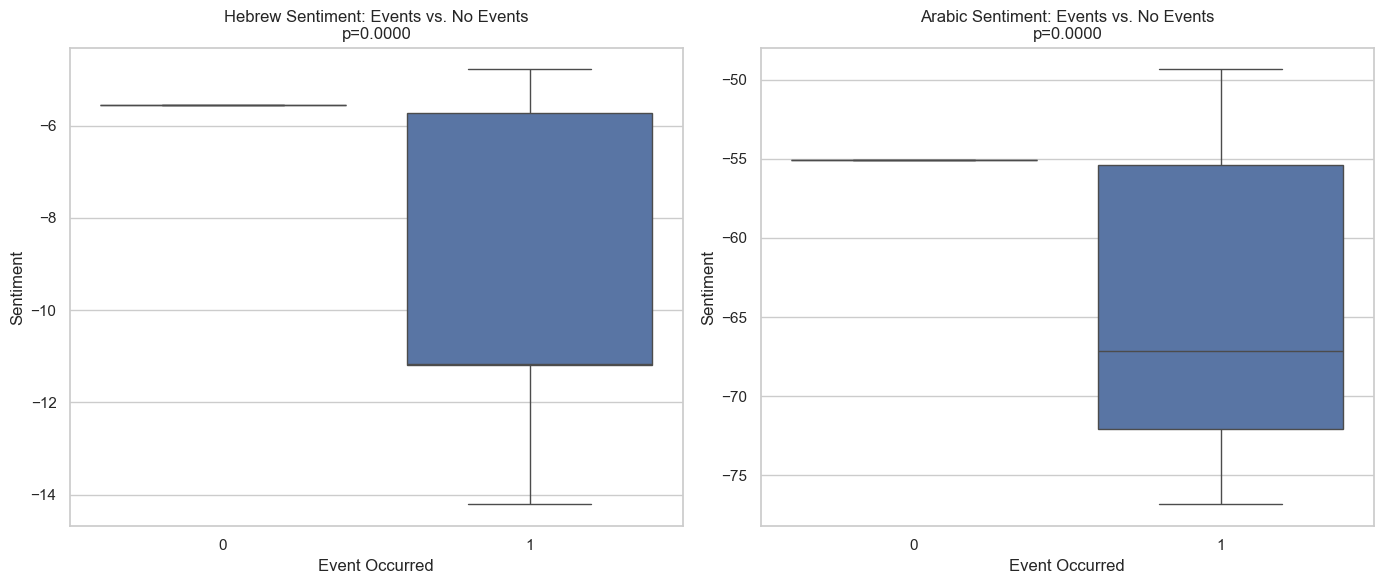

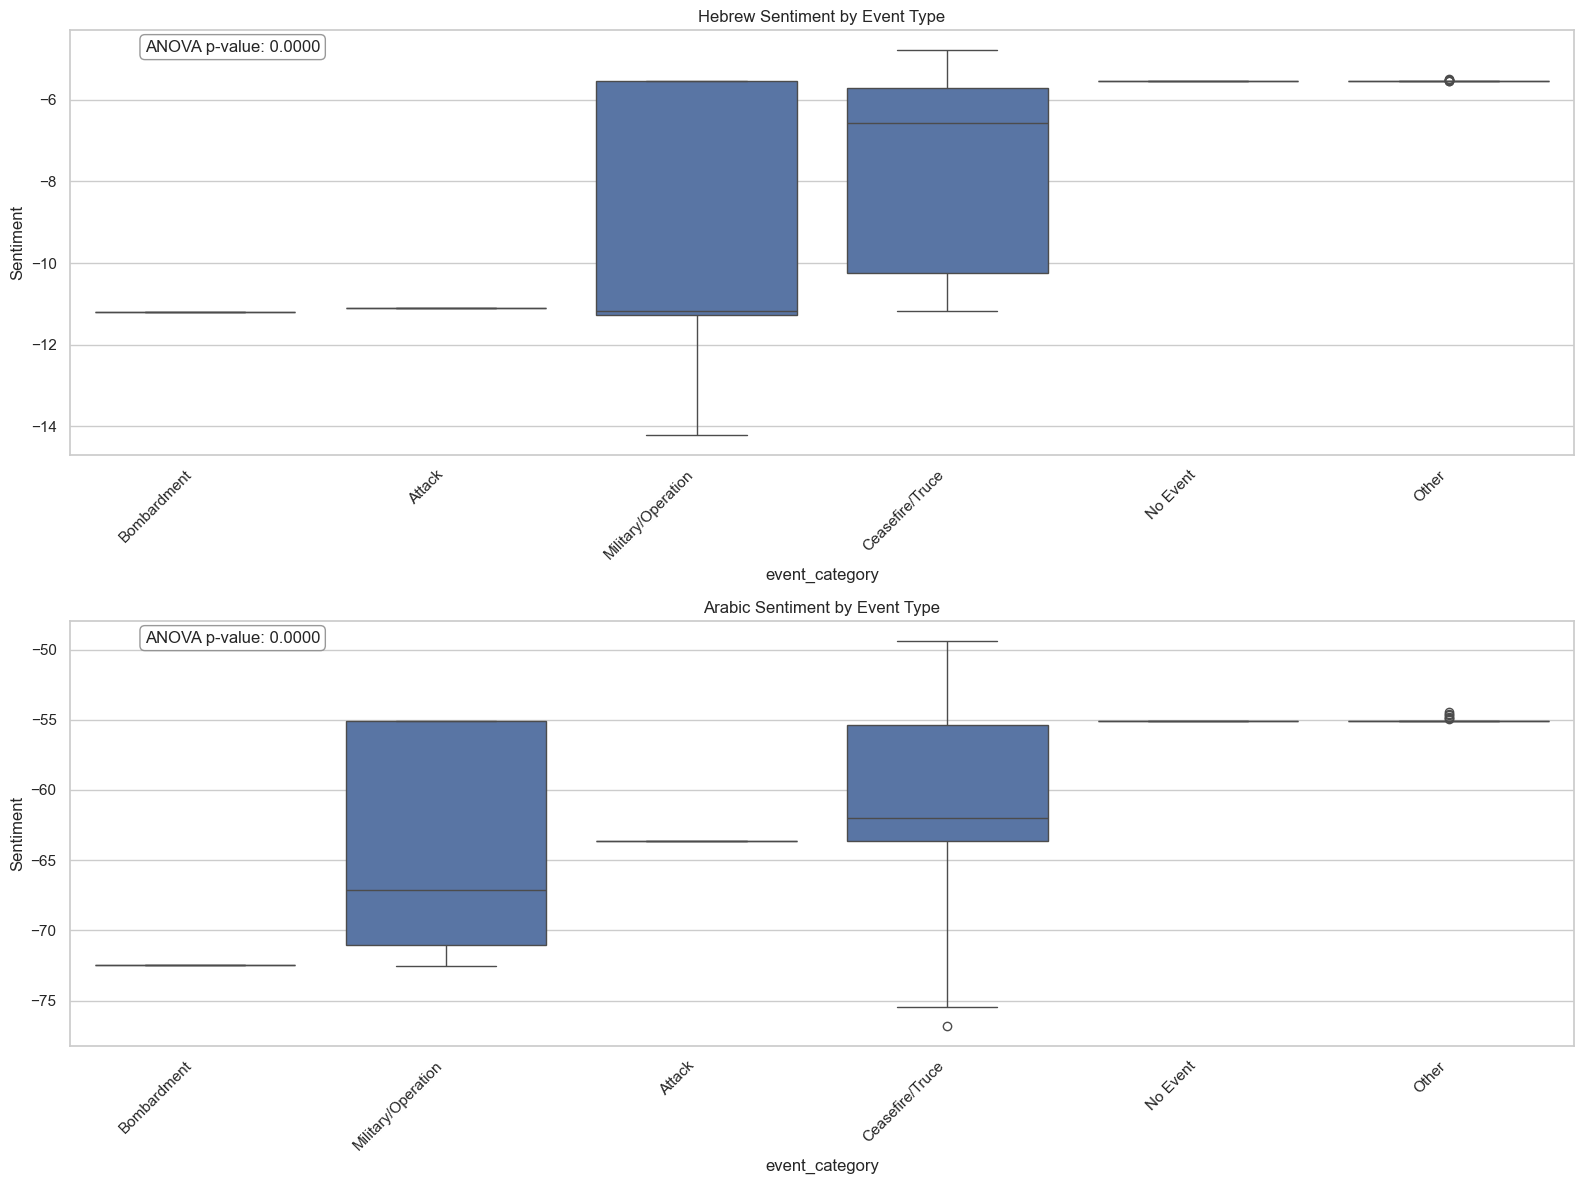

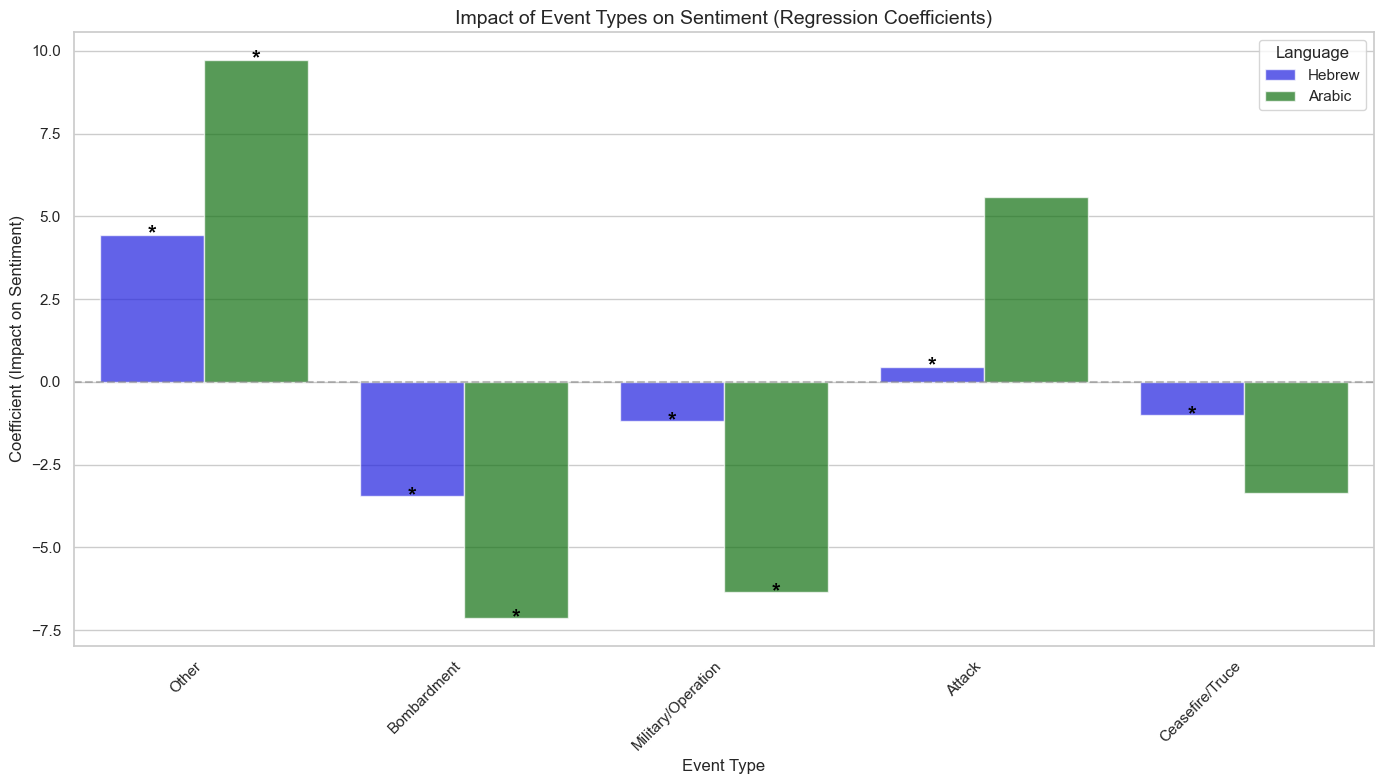

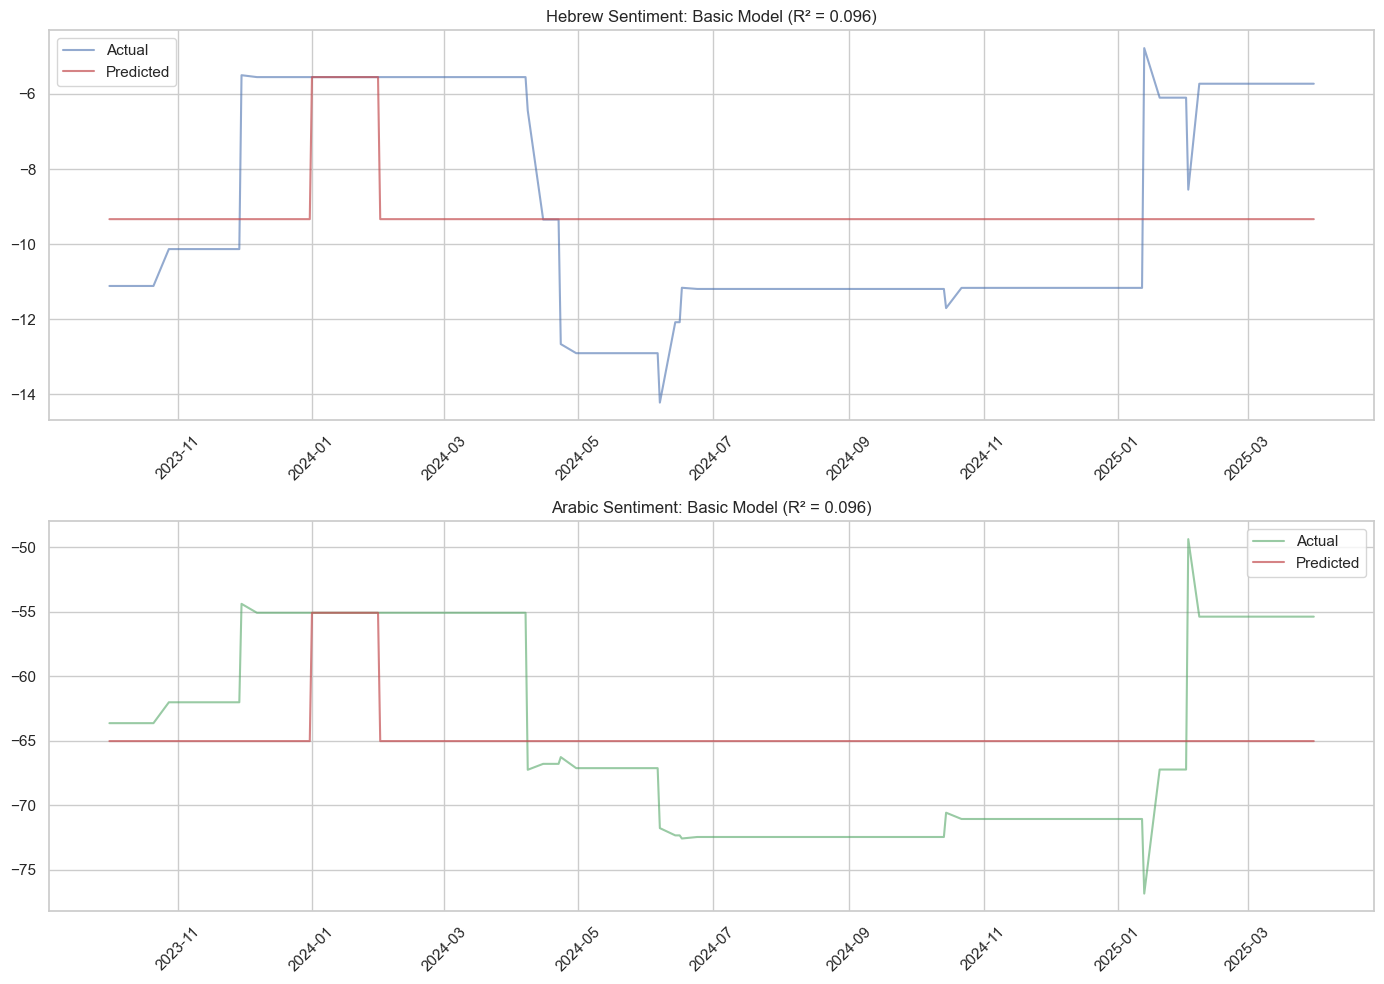

In [24]:
results = statistical_validation(
    integrated_data_path='../data/sentiment_events/integrated_events.csv',
    wiki_timeline_path='../data/wikipedia/wiki_time_periods.csv',
    output_path='../ARCHIVE/visualizations'
)

# Geopolitical and Linguistic Comparative Analysis

In [25]:
def perform_comparative_analysis(daily_df, integrated_data, output_path=None):
    """
    Perform comparative analysis of sentiment dynamics between Hebrew and Arabic messages.

    Parameters:
    -----------
    daily_df : pandas.DataFrame
        Daily timeseries with sentiment values and event flags
    integrated_data : pandas.DataFrame
        Integrated data with sentiment events and Wikipedia events
    output_path : str, optional
        Path to save visualization outputs

    Returns:
    --------
    dict
        Results of comparative analysis
    """
    # Make a copy to avoid modifying the original data
    daily_df = daily_df.copy()
    integrated_data = integrated_data.copy()

    # Ensure date is datetime
    if 'date' in daily_df.columns and not pd.api.types.is_datetime64_dtype(daily_df['date']):
        daily_df['date'] = pd.to_datetime(daily_df['date'])

    # Calculate sentiment divergence (Hebrew - Arabic)
    daily_df['sentiment_divergence'] = daily_df['hebrew_sentiment'] - daily_df['arabic_sentiment']

    # Calculate absolute magnitude of sentiment for each language
    daily_df['hebrew_magnitude'] = daily_df['hebrew_sentiment'].abs()
    daily_df['arabic_magnitude'] = daily_df['arabic_sentiment'].abs()

    # 1. Sentiment Divergence Analysis
    print("\n--- Analyzing Sentiment Divergence ---")

    # Compute basic statistics on sentiment divergence
    divergence_mean = daily_df['sentiment_divergence'].mean()
    divergence_std = daily_df['sentiment_divergence'].std()

    # Identify periods of maximum divergence
    threshold = divergence_mean + 1.5 * divergence_std
    high_divergence = daily_df[daily_df['sentiment_divergence'].abs() > threshold]

    print(f"Average sentiment divergence (Hebrew - Arabic): {divergence_mean:.2f}")
    print(f"Divergence standard deviation: {divergence_std:.2f}")
    print(f"Found {len(high_divergence)} days with high divergence (>1.5 std)")

    # Group divergence by event type
    event_types = [col for col in daily_df.columns if col.startswith('event_') and
                  not col.endswith('_lag1') and not col.endswith('_lag3') and
                  col != 'any_event' and col != 'event_category']

    # Calculate mean sentiment divergence for each event type
    divergence_by_event = {}
    for event_col in event_types:
        event_name = event_col.replace('event_', '').replace('_', '/').title()
        event_days = daily_df[daily_df[event_col] == 1]
        if len(event_days) > 0:
            mean_divergence = event_days['sentiment_divergence'].mean()
            divergence_by_event[event_name] = {
                'mean_divergence': mean_divergence,
                'count': len(event_days)
            }

    # Calculate divergence for non-event days
    non_event_days = daily_df[daily_df['any_event'] == 0]
    if len(non_event_days) > 0:
        divergence_by_event['No Event'] = {
            'mean_divergence': non_event_days['sentiment_divergence'].mean(),
            'count': len(non_event_days)
        }

    # Print divergence by event type
    print("\nSentiment Divergence by Event Type:")
    for event_name, stats in divergence_by_event.items():
        print(f"  {event_name} (n={stats['count']}): {stats['mean_divergence']:.2f}")

    # 2. Plot Sentiment Divergence Over Time
    plt.figure(figsize=(15, 6))

    # Plot the sentiment divergence
    plt.plot(daily_df['date'], daily_df['sentiment_divergence'], 'k-', alpha=0.5)

    # Add smoothed trendline
    try:
        # Use LOWESS smoothing for the trend
        lowess_result = lowess(daily_df['sentiment_divergence'],
                              mdates.date2num(daily_df['date']),
                              frac=0.1)
        plt.plot(mdates.num2date(lowess_result[:, 0]),
                lowess_result[:, 1], 'r-',
                linewidth=2, label='Trend')
    except Exception as e:
        print(f"Could not generate smoothed trendline: {str(e)}")

    # Add zero reference line
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Highlight high divergence periods
    plt.scatter(high_divergence['date'], high_divergence['sentiment_divergence'],
               color='red', s=50, alpha=0.7, label='High Divergence')

    # Add event period shading
    unique_event_types = {}
    for col in event_types:
        event_name = col.replace('event_', '').replace('_', '/').title()
        event_days = daily_df[daily_df[col] == 1]

        if len(event_days) > 0:
            # Group consecutive days into periods
            event_days = event_days.sort_values('date')
            event_periods = []
            current_period = []

            for i, (_, row) in enumerate(event_days.iterrows()):
                current_date = row['date']

                if i == 0 or (current_date - prev_date).days > 1:
                    # Start a new period
                    if current_period:
                        event_periods.append(current_period)
                    current_period = [current_date]
                else:
                    # Continue current period
                    current_period.append(current_date)

                prev_date = current_date

            # Add the last period
            if current_period:
                event_periods.append(current_period)

            # Now shade each period
            for period in event_periods:
                start_date = min(period)
                end_date = max(period) + timedelta(days=1)  # Add a day to include the full last day

                # Use a distinct color for each event type
                if event_name not in unique_event_types:
                    unique_event_types[event_name] = len(unique_event_types)

                color_idx = unique_event_types[event_name]
                colors = plt.cm.tab10.colors
                color = colors[color_idx % len(colors)]

                plt.axvspan(start_date, end_date, alpha=0.2, color=color)

                # Add annotation for first occurrence only
                handles, labels = plt.gca().get_legend_handles_labels()
                if event_name not in labels:
                    # Add a small rectangle to the plot as a proxy for the legend
                    plt.plot([], [], color=color, alpha=0.5, linewidth=10, label=event_name)

    plt.title('Sentiment Divergence Between Hebrew and Arabic Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Divergence (Hebrew - Arabic)')
    plt.legend(loc='upper right')

    # Format x-axis to show dates nicely
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/sentiment_divergence_timeline.png", dpi=300, bbox_inches='tight')

    # 3. Reaction Pattern Analysis
    print("\n--- Analyzing Reaction Patterns ---")

    # Create a reaction matrix plot (Hebrew vs. Arabic sentiment)
    plt.figure(figsize=(10, 9))

    # Create a scatter plot of Hebrew vs. Arabic sentiment
    scatter = plt.scatter(daily_df['hebrew_sentiment'], daily_df['arabic_sentiment'],
                         c=daily_df['any_event'], cmap='coolwarm',
                         alpha=0.7, s=50)

    # Add quadrant labels
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

    plt.text(daily_df['hebrew_sentiment'].max()*0.7, daily_df['arabic_sentiment'].max()*0.7,
            "Both Positive", ha='center', va='center', fontsize=12)
    plt.text(daily_df['hebrew_sentiment'].min()*0.7, daily_df['arabic_sentiment'].max()*0.7,
            "Arabic Positive\nHebrew Negative", ha='center', va='center', fontsize=12)
    plt.text(daily_df['hebrew_sentiment'].max()*0.7, daily_df['arabic_sentiment'].min()*0.7,
            "Hebrew Positive\nArabic Negative", ha='center', va='center', fontsize=12)
    plt.text(daily_df['hebrew_sentiment'].min()*0.7, daily_df['arabic_sentiment'].min()*0.7,
            "Both Negative", ha='center', va='center', fontsize=12)

    # Add regression line
    x = daily_df['hebrew_sentiment']
    y = daily_df['arabic_sentiment']
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, 'k--', alpha=0.5)

    # Calculate correlation
    try:
        from scipy import stats as scipy_stats
        correlation, p_value = scipy_stats.pearsonr(daily_df['hebrew_sentiment'], daily_df['arabic_sentiment'])
    except Exception as e:
        print(f"Error calculating correlation: {str(e)}")
        correlation, p_value = 0, 1

    plt.title(f'Hebrew vs. Arabic Sentiment (r={correlation:.2f}, p={p_value:.4f})')
    plt.xlabel('Hebrew Sentiment')
    plt.ylabel('Arabic Sentiment')

    # Add colorbar legend
    cbar = plt.colorbar(scatter)
    cbar.set_label('Event Day (1=Yes, 0=No)')

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/sentiment_reaction_matrix.png", dpi=300, bbox_inches='tight')

    # 4. Event Response Typology
    print("\n--- Creating Event Response Typology ---")

    # Define response patterns
    def categorize_response(hebrew, arabic):
        if hebrew > 0 and arabic > 0:
            return "Both Positive"
        elif hebrew < 0 and arabic < 0:
            return "Both Negative"
        elif hebrew > 0 and arabic < 0:
            return "Hebrew Positive, Arabic Negative"
        elif hebrew < 0 and arabic > 0:
            return "Hebrew Negative, Arabic Positive"
        else:
            return "Neutral"

    # Apply categorization to each day
    daily_df['response_pattern'] = daily_df.apply(
        lambda row: categorize_response(row['hebrew_sentiment'], row['arabic_sentiment']),
        axis=1
    )

    # Count response patterns by event type
    response_counts = {}

    for event_col in event_types:
        event_name = event_col.replace('event_', '').replace('_', '/').title()
        event_days = daily_df[daily_df[event_col] == 1]

        if len(event_days) > 0:
            pattern_counts = event_days['response_pattern'].value_counts()
            response_counts[event_name] = pattern_counts.to_dict()

    # Also calculate for non-event days
    non_event_days = daily_df[daily_df['any_event'] == 0]
    if len(non_event_days) > 0:
        pattern_counts = non_event_days['response_pattern'].value_counts()
        response_counts['No Event'] = pattern_counts.to_dict()

    # Create a dataframe for visualization
    response_df_rows = []

    for event_name, patterns in response_counts.items():
        total = sum(patterns.values())
        for pattern, count in patterns.items():
            response_df_rows.append({
                'Event Type': event_name,
                'Response Pattern': pattern,
                'Count': count,
                'Percentage': 100 * count / total
            })

    response_df = pd.DataFrame(response_df_rows)

    # Plot response pattern distribution
    plt.figure(figsize=(14, 8))

    # Create a grouped bar chart
    ax = sns.barplot(x='Event Type', y='Percentage', hue='Response Pattern', data=response_df)

    plt.title('Distribution of Sentiment Response Patterns by Event Type')
    plt.xlabel('Event Type')
    plt.ylabel('Percentage of Days')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Response Pattern')

    # Add percentage labels on the bars
    for i, bar in enumerate(ax.patches):
        if bar.get_height() > 5:  # Only label bars with significant percentage
            ax.text(bar.get_x() + bar.get_width()/2,
                   bar.get_height() + 0.5,
                   f'{bar.get_height():.1f}%',
                   ha='center', va='bottom',
                   fontsize=8)

    plt.tight_layout()

    if output_path:
        plt.savefig(f"{output_path}/response_pattern_distribution.png", dpi=300, bbox_inches='tight')

    # 5. Create paired sentiment trajectory plots for major events
    print("\n--- Creating Paired Sentiment Trajectory Plots ---")

    # Find the most significant events based on integrated data
    # Group by wiki_title to get event periods
    if 'wiki_title' in integrated_data.columns:
        event_periods = integrated_data.groupby('wiki_title').agg({
            'date': ['min', 'max'],
            'hebrew_sentiment': 'mean',
            'arabic_sentiment': 'mean',
            'wiki_period': 'first'
        })

        # Flatten the MultiIndex columns
        event_periods.columns = ['start_date', 'end_date', 'hebrew_sentiment', 'arabic_sentiment', 'period']

        # Sort by the absolute difference in sentiment
        event_periods['sentiment_diff'] = abs(event_periods['hebrew_sentiment'] - event_periods['arabic_sentiment'])
        event_periods = event_periods.sort_values('sentiment_diff', ascending=False)

        # Select top events for visualization (max 4)
        top_events = event_periods.head(min(4, len(event_periods)))

        # Create a multi-panel plot for each top event
        if len(top_events) > 0:
            fig, axes = plt.subplots(len(top_events), 1, figsize=(14, 4*len(top_events)))
            if len(top_events) == 1:
                axes = [axes]  # Make axes iterable when there's only one subplot

            for i, (title, event) in enumerate(top_events.iterrows()):
                # Get the event period plus a buffer
                buffer_days = 5
                start_date = event['start_date'] - timedelta(days=buffer_days)
                end_date = event['end_date'] + timedelta(days=buffer_days)

                # Filter daily data for this period
                period_data = daily_df[(daily_df['date'] >= start_date) & (daily_df['date'] <= end_date)]

                if len(period_data) > 0:
                    # Plot both sentiment lines
                    axes[i].plot(period_data['date'], period_data['hebrew_sentiment'],
                                'b-', label='Hebrew', linewidth=2)
                    axes[i].plot(period_data['date'], period_data['arabic_sentiment'],
                                'g-', label='Arabic', linewidth=2)

                    # Add shading for the actual event period
                    axes[i].axvspan(event['start_date'], event['end_date'],
                                   alpha=0.2, color='gray')

                    # Add zero reference line
                    axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

                    # Set title and labels
                    short_title = title[:50] + '...' if len(title) > 50 else title
                    axes[i].set_title(f"{short_title} ({event['period']})")
                    axes[i].set_xlabel('Date')
                    axes[i].set_ylabel('Sentiment')

                    # Format x-axis
                    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
                    axes[i].tick_params(axis='x', rotation=45)

                    # Add legend
                    axes[i].legend()

            plt.tight_layout()

            if output_path:
                plt.savefig(f"{output_path}/paired_sentiment_trajectories.png", dpi=300, bbox_inches='tight')

    # 6. Calculate summary statistics
    print("\n--- Calculating Summary Statistics ---")

    # Correlation between Hebrew and Arabic sentiment during different events
    correlation_by_event = {}
    for event_col in event_types:
        event_name = event_col.replace('event_', '').replace('_', '/').title()
        event_days = daily_df[daily_df[event_col] == 1]

        if len(event_days) >= 5:  # Need enough data points for correlation
            try:
                from scipy import stats as scipy_stats
                corr, p = scipy_stats.pearsonr(event_days['hebrew_sentiment'], event_days['arabic_sentiment'])
                correlation_by_event[event_name] = {
                    'correlation': corr,
                    'p_value': p,
                    'significant': p < 0.05,
                    'count': len(event_days)
                }
            except Exception as e:
                print(f"Could not calculate correlation for {event_name}: {str(e)}")
                correlation_by_event[event_name] = {
                    'correlation': float('nan'),
                    'p_value': float('nan'),
                    'significant': False,
                    'count': len(event_days)
                }

    # Overall correlation
    try:
        from scipy import stats as scipy_stats
        overall_corr, overall_p = scipy_stats.pearsonr(daily_df['hebrew_sentiment'], daily_df['arabic_sentiment'])
        correlation_by_event['Overall'] = {
            'correlation': overall_corr,
            'p_value': overall_p,
            'significant': overall_p < 0.05,
            'count': len(daily_df)
        }
    except Exception as e:
        print(f"Could not calculate overall correlation: {str(e)}")
        correlation_by_event['Overall'] = {
            'correlation': float('nan'),
            'p_value': float('nan'),
            'significant': False,
            'count': len(daily_df)
        }

    # Print correlation results
    print("\nCorrelation Between Hebrew and Arabic Sentiment:")
    for event_name, stats_dict in correlation_by_event.items():
        sig_str = "SIGNIFICANT" if stats_dict['significant'] else "not significant"
        print(f"  {event_name} (n={stats_dict['count']}): r={stats_dict['correlation']:.2f}, p={stats_dict['p_value']:.4f} ({sig_str})")

    # Calculate relationship between sentiment magnitude and divergence
    try:
        from scipy import stats as scipy_stats
        mag_corr, mag_p = scipy_stats.pearsonr(
            daily_df['hebrew_magnitude'] + daily_df['arabic_magnitude'],
            daily_df['sentiment_divergence'].abs()
        )

        print(f"\nRelationship between sentiment intensity and divergence:")
        print(f"  Correlation: r={mag_corr:.2f}, p={mag_p:.4f}")

        if mag_p < 0.05:
            direction = "stronger" if mag_corr > 0 else "weaker"
            print(f"  SIGNIFICANT: Higher intensity events tend to have {direction} divergence")
        else:
            print("  No significant relationship between intensity and divergence")
    except Exception as e:
        print(f"Could not calculate magnitude correlation: {str(e)}")

    # 7. Create summary comparison table
    summary_table = []
    for event_col in event_types:
        event_name = event_col.replace('event_', '').replace('_', '/').title()
        event_days = daily_df[daily_df[event_col] == 1]

        if len(event_days) > 0:
            summary_table.append({
                'Event Type': event_name,
                'Count': len(event_days),
                'Hebrew Mean': event_days['hebrew_sentiment'].mean(),
                'Arabic Mean': event_days['arabic_sentiment'].mean(),
                'Sentiment Gap': event_days['sentiment_divergence'].mean(),
                'Hebrew Volatility': event_days['hebrew_sentiment'].std(),
                'Arabic Volatility': event_days['arabic_sentiment'].std(),
            })

    # Add non-event days
    non_event_days = daily_df[daily_df['any_event'] == 0]
    if len(non_event_days) > 0:
        summary_table.append({
            'Event Type': 'No Event',
            'Count': len(non_event_days),
            'Hebrew Mean': non_event_days['hebrew_sentiment'].mean(),
            'Arabic Mean': non_event_days['arabic_sentiment'].mean(),
            'Sentiment Gap': non_event_days['sentiment_divergence'].mean(),
            'Hebrew Volatility': non_event_days['hebrew_sentiment'].std(),
            'Arabic Volatility': non_event_days['arabic_sentiment'].std(),
        })

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_table)

    # Print summary table
    print("\nSummary Comparison Table:")
    print(summary_df.round(2).to_string(index=False))

    # Save summary table if output path is provided
    if output_path:
        summary_df.to_csv(f"{output_path}/sentiment_comparison_summary.csv", index=False)
        print(f"Summary table saved to {output_path}/sentiment_comparison_summary.csv")

    # Return results
    return {
        'sentiment_divergence': divergence_by_event,
        'correlation_by_event': correlation_by_event,
        'response_patterns': response_counts,
        'summary_table': summary_df
    }

# Main execution function
def geopolitical_comparative_analysis(integrated_data_path, daily_timeseries_path, output_path=None):
    """
    Perform geopolitical and linguistic comparative analysis.

    Parameters:
    -----------
    integrated_data_path : str
        Path to the CSV file containing integrated sentiment events
    daily_timeseries_path : str
        Path to the CSV file containing daily timeseries data
    output_path : str, optional
        Path to save visualization outputs

    Returns:
    --------
    dict
        Results of comparative analysis
    """
    # Load the data
    integrated_data = pd.read_csv(integrated_data_path)
    daily_df = pd.read_csv(daily_timeseries_path)

    # Convert dates to datetime
    integrated_data['date'] = pd.to_datetime(integrated_data['date'])
    daily_df['date'] = pd.to_datetime(daily_df['date'])

    # Perform comparative analysis
    return perform_comparative_analysis(daily_df, integrated_data, output_path)


--- Analyzing Sentiment Divergence ---
Average sentiment divergence (Hebrew - Arabic): 55.34
Divergence standard deviation: 5.30
Found 6 days with high divergence (>1.5 std)

Sentiment Divergence by Event Type:
  Military/Operation (n=305): 56.16
  Ceasefire/Truce (n=151): 53.08
  Other (n=31): 49.46
  Bombardment (n=92): 61.26
  Attack (n=1): 52.52
  No Event (n=31): 49.52

--- Analyzing Reaction Patterns ---

--- Creating Event Response Typology ---

--- Creating Paired Sentiment Trajectory Plots ---

--- Calculating Summary Statistics ---

Correlation Between Hebrew and Arabic Sentiment:
  Military/Operation (n=305): r=0.85, p=0.0000 (SIGNIFICANT)
  Ceasefire/Truce (n=151): r=0.46, p=0.0000 (SIGNIFICANT)
  Other (n=31): r=1.00, p=0.0000 (SIGNIFICANT)
  Bombardment (n=92): r=nan, p=nan (not significant)
  Overall (n=548): r=0.84, p=0.0000 (SIGNIFICANT)

Relationship between sentiment intensity and divergence:
  Correlation: r=0.90, p=0.0000
  SIGNIFICANT: Higher intensity events ten

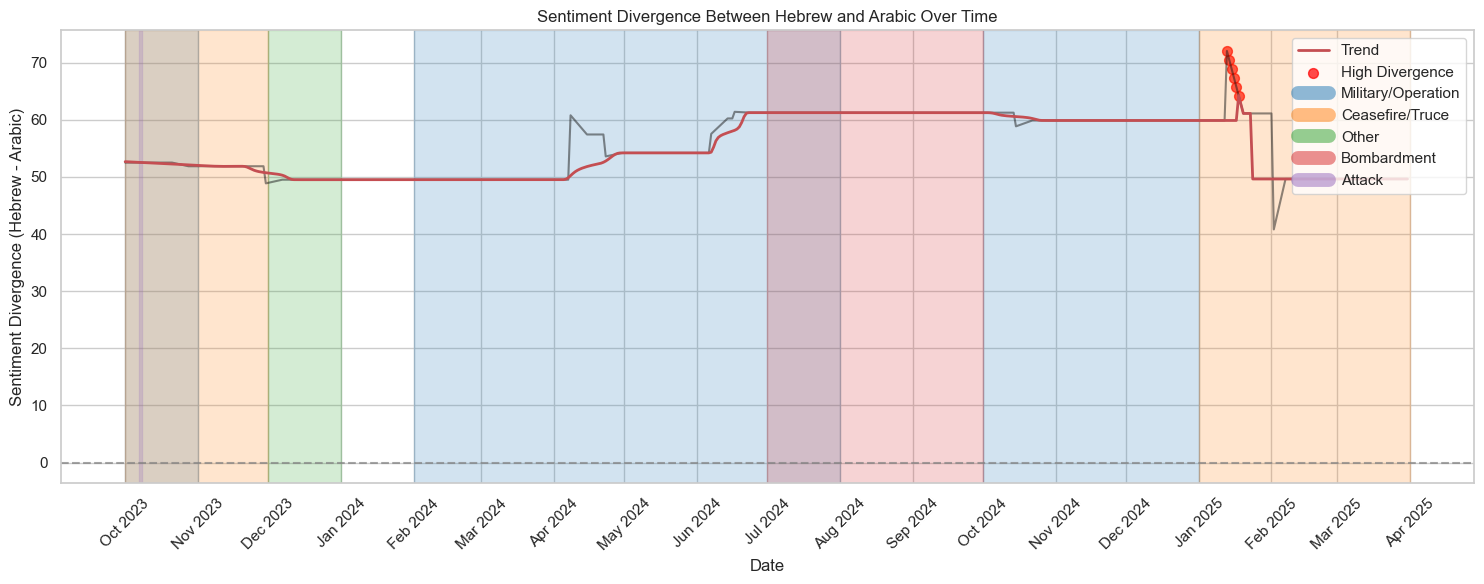

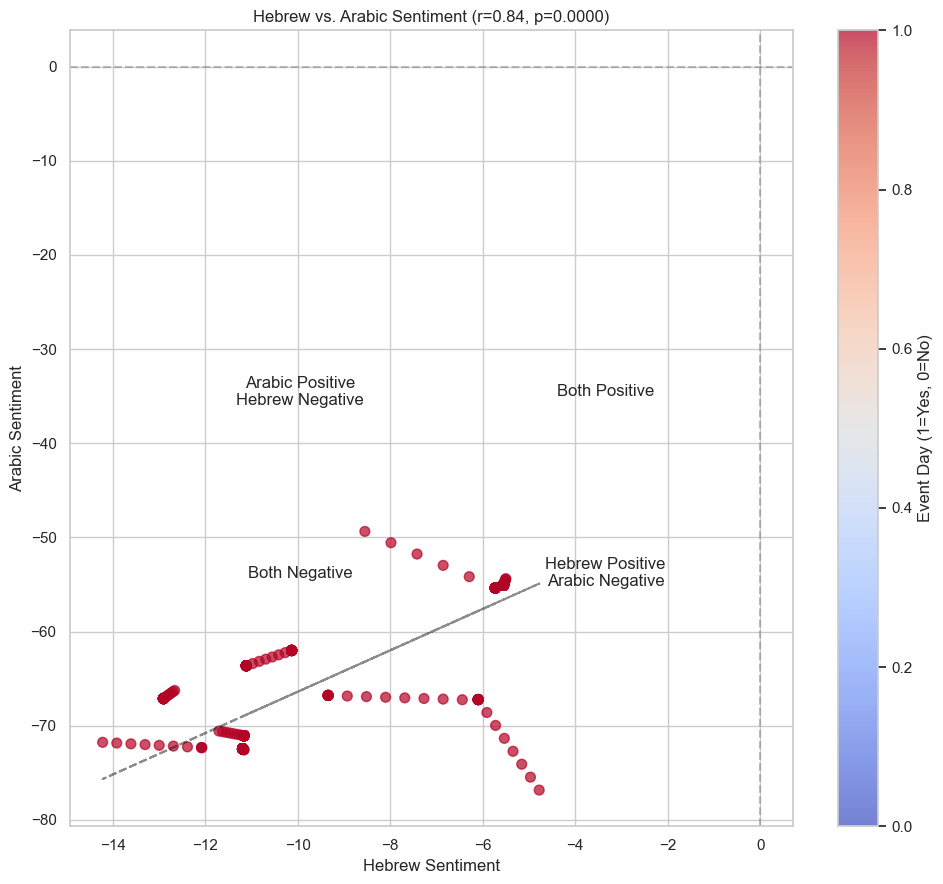

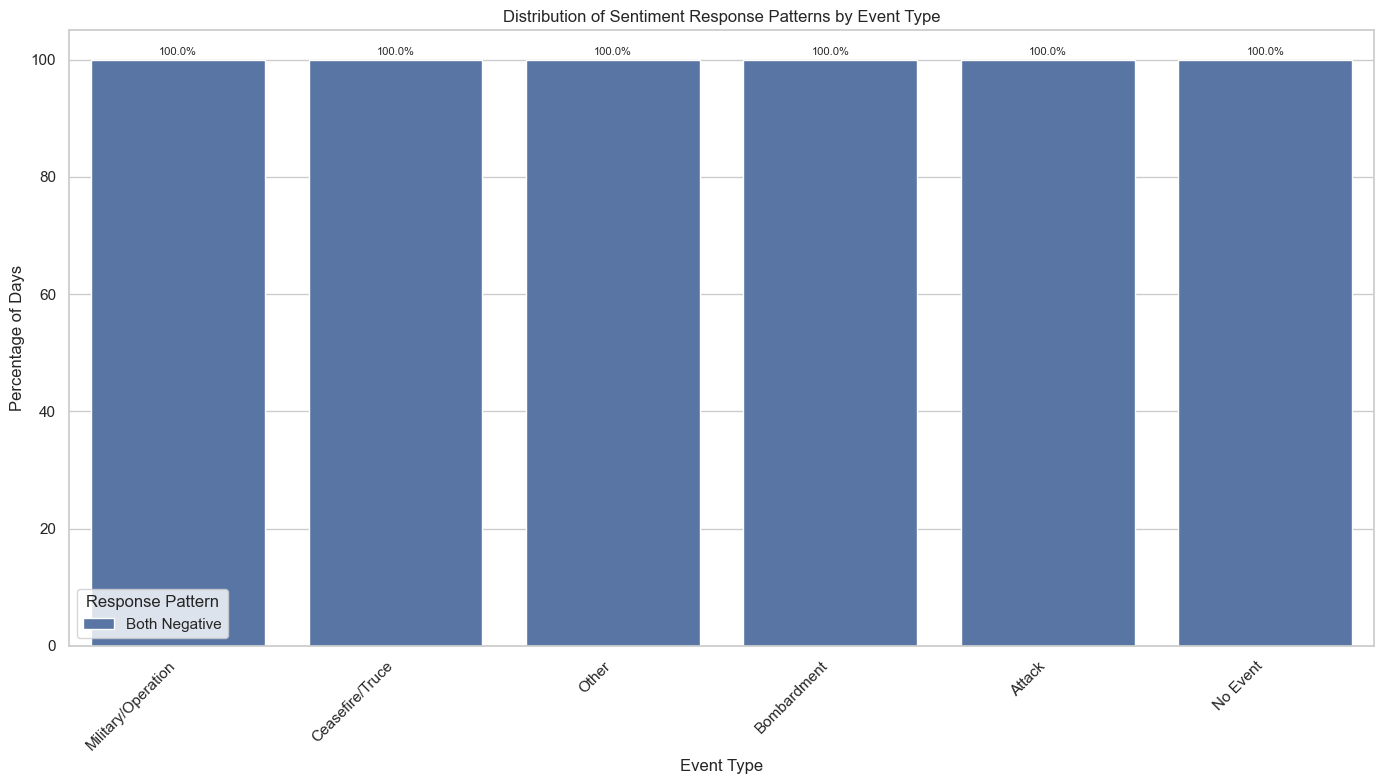

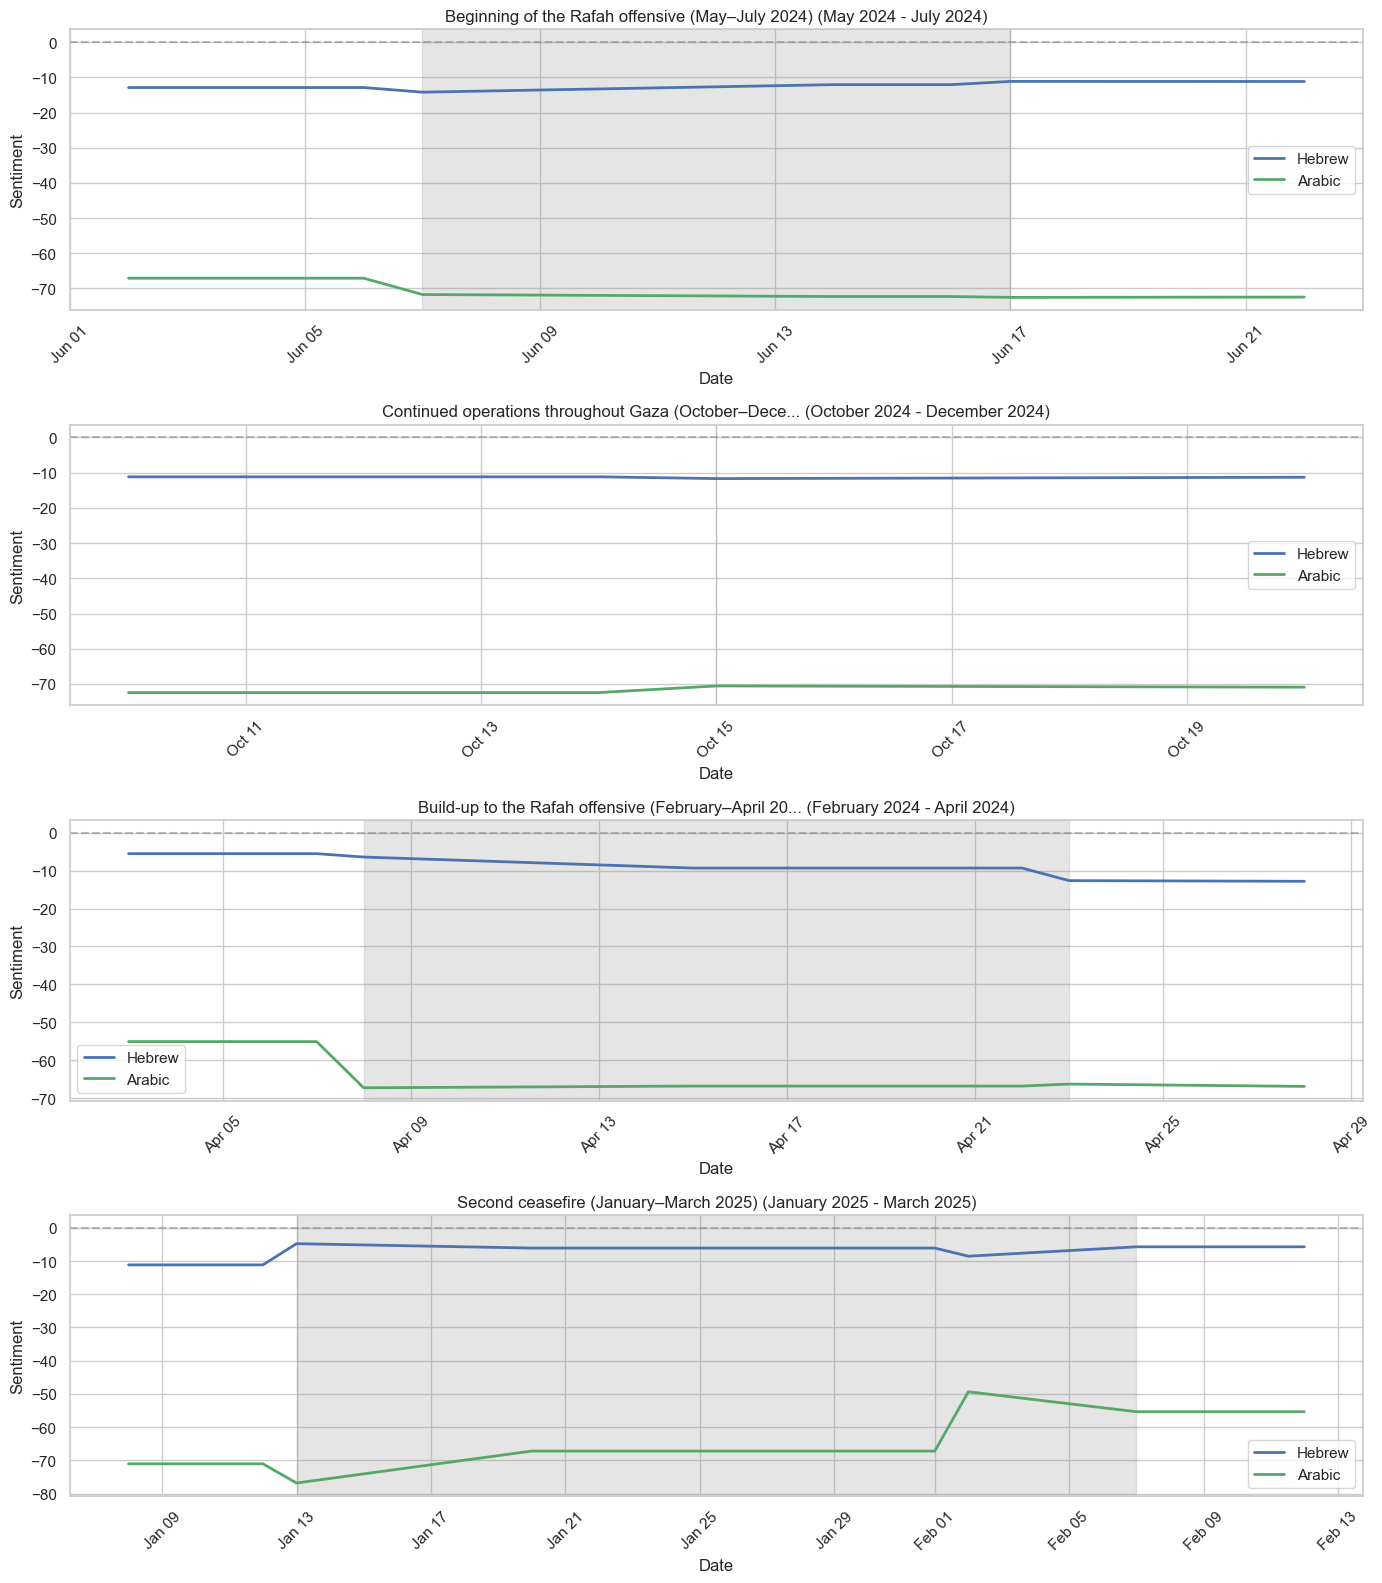

In [26]:
results = geopolitical_comparative_analysis(
    integrated_data_path='../data/sentiment_events/integrated_events.csv',
    daily_timeseries_path='../data/sentiment_events/daily_timeseries.csv',
    output_path='../ARCHIVE/visualizations'
)

## Sentiment Divergence Between Hebrew and Arabic Over Time

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.cm as cm

def plot_sentiment_divergence(daily_df, output_path=None):
    """
    Create a visualization of sentiment divergence between Hebrew and Arabic over time.

    Parameters:
    -----------
    daily_df : pandas.DataFrame
        Daily timeseries with sentiment values and event flags
    output_path : str, optional
        Path to save visualization output, if None will display instead
    """
    # Make a copy to avoid modifying the original data
    daily_df = daily_df.copy()

    # Ensure date is datetime
    if 'date' in daily_df.columns and not pd.api.types.is_datetime64_dtype(daily_df['date']):
        daily_df['date'] = pd.to_datetime(daily_df['date'])

    # Calculate sentiment divergence (Hebrew - Arabic)
    daily_df['sentiment_divergence'] = daily_df['hebrew_sentiment'] - daily_df['arabic_sentiment']

    # Compute basic statistics on sentiment divergence
    divergence_mean = daily_df['sentiment_divergence'].mean()
    divergence_std = daily_df['sentiment_divergence'].std()

    # Identify periods of maximum divergence
    threshold = divergence_mean + 1.5 * divergence_std
    high_divergence = daily_df[daily_df['sentiment_divergence'].abs() > threshold]

    # Find event type columns
    event_types = [col for col in daily_df.columns if col.startswith('event_') and
                  not col.endswith('_lag1') and not col.endswith('_lag3') and
                  col != 'any_event' and col != 'event_category']

    # Set larger font sizes for all elements
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    LARGE_SIZE = 18
    TITLE_SIZE = 20

    plt.rc('font', size=SMALL_SIZE)         # default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)    # axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # x tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # y tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend
    plt.rc('figure', titlesize=TITLE_SIZE)   # figure title

    # 2. Plot Sentiment Divergence Over Time
    plt.figure(figsize=(15, 8))

    # Plot the sentiment divergence
    plt.plot(daily_df['date'], daily_df['sentiment_divergence'], 'k-', alpha=0.5)

    # Add smoothed trendline
    try:
        # Use LOWESS smoothing for the trend
        lowess_result = lowess(daily_df['sentiment_divergence'],
                              mdates.date2num(daily_df['date']),
                              frac=0.1)
        plt.plot(mdates.num2date(lowess_result[:, 0]),
                lowess_result[:, 1], 'r-',
                linewidth=2, label='Trend')
    except Exception as e:
        print(f"Could not generate smoothed trendline: {str(e)}")

    # Add zero reference line
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Highlight high divergence periods
    plt.scatter(high_divergence['date'], high_divergence['sentiment_divergence'],
               color='red', s=50, alpha=0.7, label='High Divergence')

    # Add event period shading
    unique_event_types = {}
    for col in event_types:
        event_name = col.replace('event_', '').replace('_', '/').title()
        event_days = daily_df[daily_df[col] == 1]

        if len(event_days) > 0:
            # Group consecutive days into periods
            event_days = event_days.sort_values('date')
            event_periods = []
            current_period = []
            prev_date = None

            for i, (_, row) in enumerate(event_days.iterrows()):
                current_date = row['date']

                if i == 0 or (prev_date is None) or (current_date - prev_date).days > 1:
                    # Start a new period
                    if current_period:
                        event_periods.append(current_period)
                    current_period = [current_date]
                else:
                    # Continue current period
                    current_period.append(current_date)

                prev_date = current_date

            # Add the last period
            if current_period:
                event_periods.append(current_period)

            # Now shade each period
            for period in event_periods:
                start_date = min(period)
                end_date = max(period) + timedelta(days=1)  # Add a day to include the full last day

                # Use a distinct color for each event type
                if event_name not in unique_event_types:
                    unique_event_types[event_name] = len(unique_event_types)

                color_idx = unique_event_types[event_name]
                colors = plt.cm.tab10.colors
                color = colors[color_idx % len(colors)]

                plt.axvspan(start_date, end_date, alpha=0.2, color=color)

                # Add annotation for first occurrence only
                handles, labels = plt.gca().get_legend_handles_labels()
                if event_name not in labels:
                    # Add a small rectangle to the plot as a proxy for the legend
                    plt.plot([], [], color=color, alpha=0.5, linewidth=10, label=event_name)

    # plt.title('Sentiment Divergence Between Hebrew and Arabic Over Time', fontsize=TITLE_SIZE)
    plt.xlabel('Date', fontsize=LARGE_SIZE)
    plt.ylabel('Sentiment Divergence (Hebrew - Arabic)', fontsize=LARGE_SIZE)

    # Format x-axis to show dates nicely
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3)

    # Position the legend outside the plot to avoid overlap
    # First adjust the figure size to make room for the legend
    fig = plt.gcf()
    fig.set_size_inches(18, 8)  # Wider figure to accommodate legend

    # Get box for the plot to shrink width and leave space for legend
    box = plt.gca().get_position()
    plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Place legend to the right of the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=MEDIUM_SIZE)

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout but leave space for legend

    # Save or show the figure
    if output_path:
        plt.savefig(f"{output_path}/sentiment_divergence_timeline.pdf", dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {output_path}/sentiment_divergence_timeline.pdf")
    else:
        plt.show()

    return plt.gcf()  # Return the figure object

Visualization saved to ../figs/sentiment_divergence_timeline.pdf


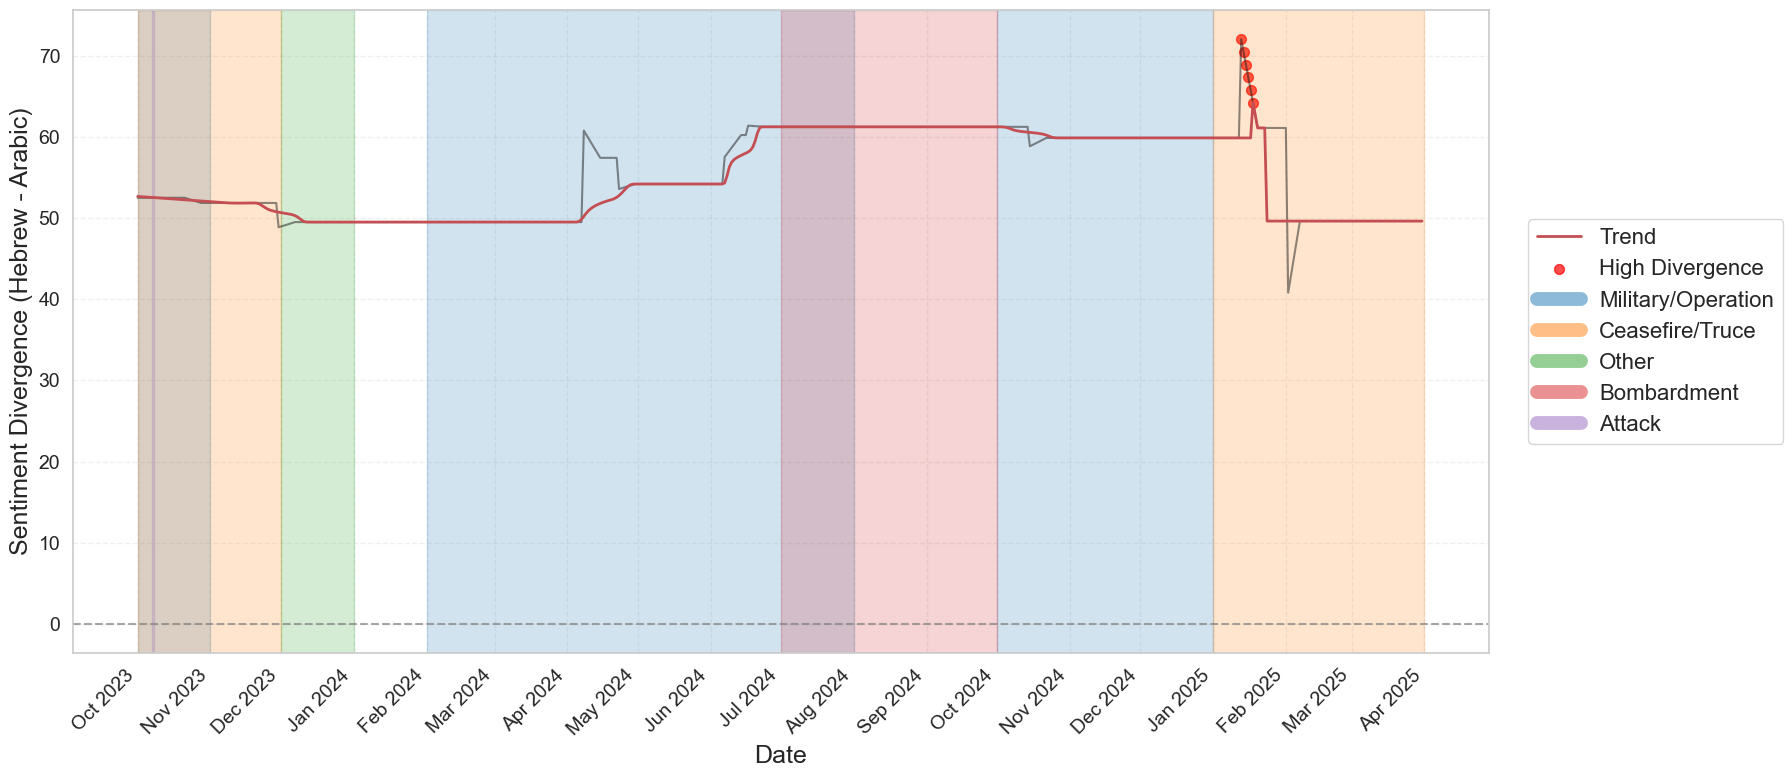

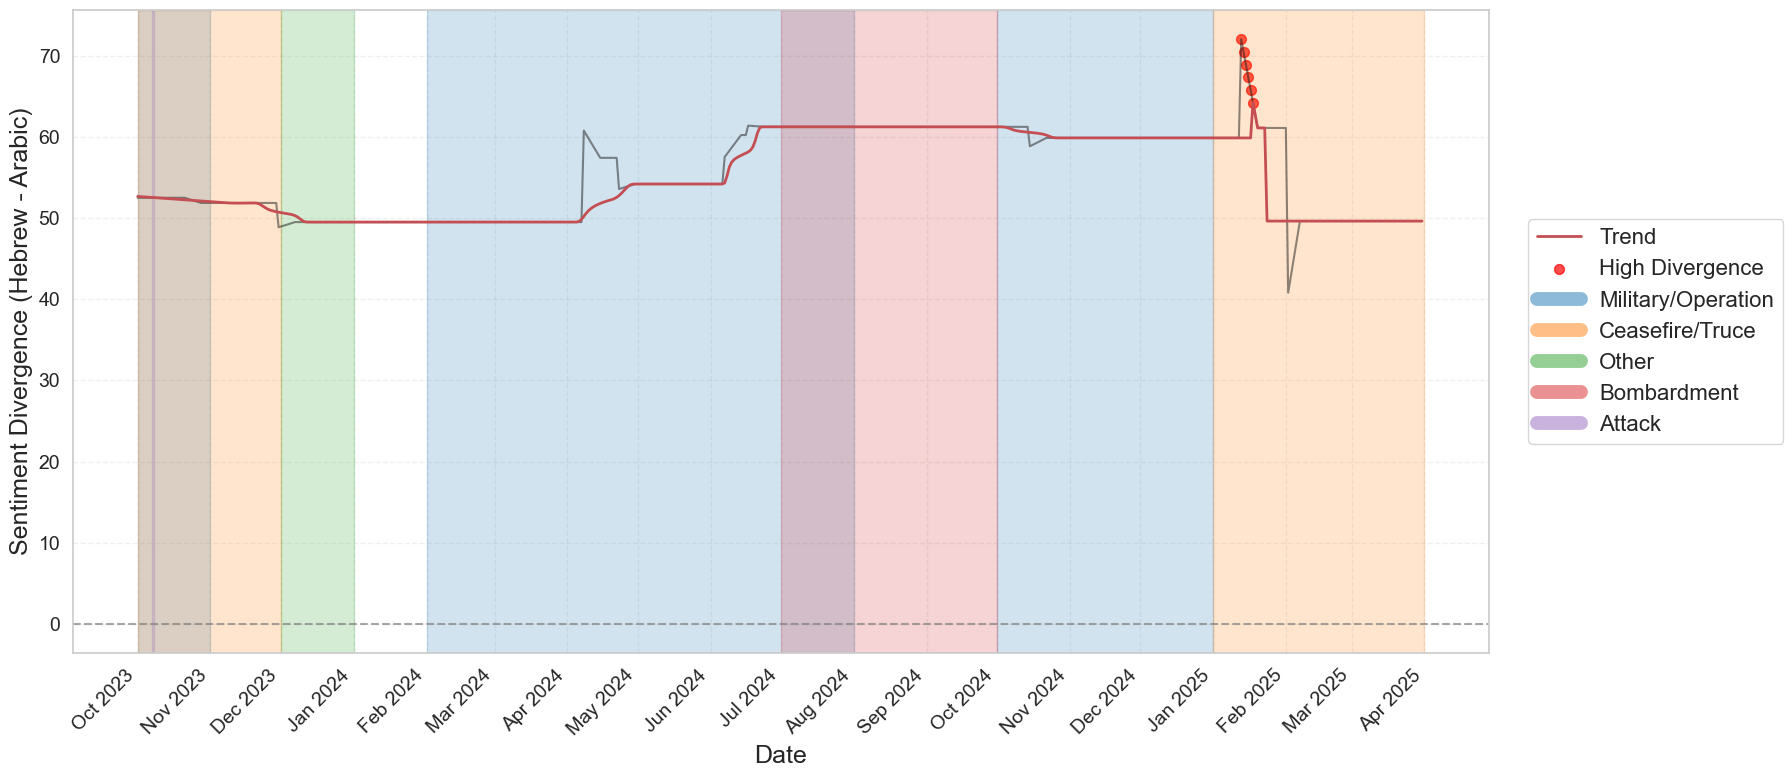

In [37]:
daily_df = pd.read_csv('../data/sentiment_events/daily_timeseries.csv')
plot_sentiment_divergence(daily_df, '../figs')